In [1]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer

# Tic Toc Toe environment

Our 1st game is the famous Tic Toc Toe. You can read about the game and its rules here: https://en.wikipedia.org/wiki/Tic-tac-toe

We implemented the game as an environment in the style of games in the [Python GYM library](https://gym.openai.com/). The commented source code is available in the file "tic_env.py". Here, we give a brief introduction to the environment and how it can be used.

### Initialization and attributes

You can initialize the environment / game as following:

In [2]:
env = TictactoeEnv()

Which then has the following attributes with the corresponding initial values:

In [3]:
env.__dict__

{'grid': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'end': False,
 'winner': None,
 'player2value': {'X': 1, 'O': -1},
 'num_step': 0,
 'current_player': 'X'}

The game is played by two players: player 'X' and player 'O'. The attribute 'current_player' shows whose turn it is. We assume that player 'X' always plays first.

The attribute 'grid' is a 3x3 numpy array and presents the board in the real game and the state $s_t$ in the reinfocement learning language. Each elements can take a value in {0, 1, -1}:
     0 : place unmarked
     1 : place marked with X 
    -1 : place marked with O 
        
The attribute 'end' shows if the game is over or not, and the attribute 'winner' shows the winner of the game: either "X", "O", or None.  

You can use function 'render' to visualize the current position of the board:

In [5]:
env.render()

|- - -|
|- - -|
|- - -|



### Taking actions

The game environment will recieve action from two players in turn and update the grid. At each time, one player can take the action $a_t$, where $a_t$ can either be an integer between 0 to 8 or a touple, corresponding to the 9 possible.

Function 'step' is used to recieve the action of the player, update the grid:

In [68]:
env.step(6)

(array([[0., 0., 0.],
        [0., 0., 0.],
        [1., 0., 0.]]),
 False,
 None)

In [19]:
env.render()

|- - O|
|- O X|
|X X O|



In [8]:
env.__dict__

{'grid': array([[0., 0., 1.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'end': False,
 'winner': None,
 'player2value': {'X': 1, 'O': -1},
 'num_step': 1,
 'current_player': 'O'}

In [9]:
env.step((1,1))

(array([[ 0.,  0.,  1.],
        [ 0., -1.,  0.],
        [ 0.,  0.,  0.]]),
 False,
 None)

In [10]:
env.render()

|- - X|
|- O -|
|- - -|



In [11]:
env.__dict__

{'grid': array([[ 0.,  0.,  1.],
        [ 0., -1.,  0.],
        [ 0.,  0.,  0.]]),
 'end': False,
 'winner': None,
 'player2value': {'X': 1, 'O': -1},
 'num_step': 2,
 'current_player': 'X'}

But not all actions are available at each time: One cannot choose a place which has been taken before. There is an error if an unavailable action is taken:

In [73]:
env.step((0,2))

ValueError: There is already a chess on position (0, 2).

### Reward

Reward is always 0 until the end of the game. When the game is over, the reward is 1 if you win the game, -1 if you lose, and 0 besides. Function 'observe' can be used after each step to recieve the new state $s_t$, whether the game is over, and the winner, and function 'reward' to get the reward value $r_t$:

In [12]:
env.observe()

(array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 1.]]),
 False,
 None)

In [14]:
env.reward(player='X')

0

In [15]:
env.reward(player='O')

0

An example of finishing the game:

In [16]:
env.step(0)
env.step(3)
env.step(1)

(array([[ 1.,  1.,  1.],
        [-1., -1.,  0.],
        [ 0.,  0.,  0.]]),
 True,
 'X')

In [17]:
env.render()

|X X X|
|O O -|
|- - -|



In [18]:
env.observe()

(array([[ 1.,  1.,  1.],
        [-1., -1.,  0.],
        [ 0.,  0.,  0.]]),
 True,
 'X')

In [19]:
env.reward(player='X')

1

In [20]:
env.reward(player='O')

-1

# Optimal policy for Tic Toc Toe environment

Fortunately, we know the exact optimal policy for Tic Toc Toe. We have implemented and $\epsilon$-greedy version of optimal polciy which you can use for the project.

In [21]:
env.reset();

In [14]:
opt_player = OptimalPlayer(epsilon = 0., player = 'X')

In [23]:
opt_player.act(env.grid)

(2, 0)

In [24]:
opt_player.player

'X'

### An example of optimal player playing against random player

In [2]:
Turns = np.array(['X','O'])
for i in range(5):
    env.reset()
    grid, _, __ = env.observe()
    Turns = Turns[np.random.permutation(2)]
    player_opt = OptimalPlayer(epsilon=0., player=Turns[0])
    player_rnd = OptimalPlayer(epsilon=1., player=Turns[1])
    for j in range(9):
        if env.current_player == player_opt.player:
            move = player_opt.act(grid)
        else:
            move = player_rnd.act(grid)

        grid, end, winner = env.step(move, print_grid=False)

        if end:
            print('-------------------------------------------')
            print('Game end, winner is player ' + str(winner))
            print('Optimal player = ' +  Turns[0])
            print('Random player = ' +  Turns[1])
            env.render()
            env.reset()
            break


-------------------------------------------
Game end, winner is player X
Optimal player = X
Random player = O
|O - X|
|- X O|
|X - -|

-------------------------------------------
Game end, winner is player X
Optimal player = X
Random player = O
|X O -|
|- X O|
|- - X|

-------------------------------------------
Game end, winner is player X
Optimal player = X
Random player = O
|O - O|
|- X O|
|X X X|

-------------------------------------------
Game end, winner is player O
Optimal player = O
Random player = X
|X - O|
|- O X|
|O - X|

-------------------------------------------
Game end, winner is player None
Optimal player = O
Random player = X
|O X O|
|X O X|
|X O X|



### An example of optimal player playing against optimal player

In [1]:
Turns = np.array(['X','O'])
for i in range(5):
    env.reset()
    grid, _, __ = env.observe()
    Turns = Turns[np.random.permutation(2)]
    player_opt_1 = OptimalPlayer(epsilon=0., player=Turns[0])
    player_opt_2 = OptimalPlayer(epsilon=0., player=Turns[1])
    for j in range(9):
        if env.current_player == player_opt.player:
            move = player_opt_1.act(grid)
        else:
            move = player_opt_2.act(grid)

        grid, end, winner = env.step(move, print_grid=False)

        if end:
            print('-------------------------------------------')
            print('Game end, winner is player ' + str(winner))
            print('Optimal player 1 = ' +  Turns[0])
            print('Optimal player 2 = ' +  Turns[1])
            env.render()
            env.reset()
            break


NameError: name 'np' is not defined

### Q-Learning algorithm

In [1]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
env = TictactoeEnv()

from collections import defaultdict
import random
class Q_Player:
    '''
    Description:
        A class to implement a Q-Learning optimal player in Tic-tac-toe.

    Parameters:
        epsilon: float, in [0, 1]. This is a value between 0-1 that indicates the
            probability of making a random action instead of the optimal action
            at any given time.
        alpha: float, in [0, 1]. This is the learning rate
        gamma: float, in [0, 1]. This is the discount factor

    '''
    def __init__(self, epsilon=0.2, player='X'):
        self.epsilon = epsilon
        self.player = player # 'x' or 'O'
#         self.qvals = qvals # q values for each state
#         self.assignment = assignment # id to label different grids

    def set_player(self, player = 'X', j=-1):
        self.player = player
        if j != -1:
            self.player = 'X' if j % 2 == 0 else 'O'

    def empty(self, grid):
        '''return all empty positions'''
        avail = []
        for i in range(9):
            pos = (int(i/3), i % 3)
            if grid[pos] == 0:
                avail.append(pos)
        return avail
    
    def eps_greedyMove(self, grid, assignment, qvals, val = None):
        """ Return the move with the optimal Q-value according to a epsilon-greedy policy. """
        self.qvals = qvals
        self.assignment = assignment
        grid_id = self.assignment[str(grid)]
        positions = np.full(9, True)
        if val is None:
            val = 1 if self.player == 'X' else -1
        for pos in self.empty(grid):
            grid_ = np.copy(grid)
            grid_[pos] = val            
            action = convert(pos)
            positions[action] = False
#             next_grid_id = self.assignment[str(grid_)]
#             if next_grid_id not in self.neighbours:
#                 self.neighbours[grid_id].append(next_grid_id)
        if random.random() < self.epsilon:
            move = self.randomMove(grid)
            return move
        else:
            self.qvals[grid_id][positions] = np.nan
            best_move = int(np.nanargmax(self.qvals[grid_id]))
            return best_move
        
    def return_dicts(self):
        return self.assignment, self.qvals

    def randomMove(self, grid):
        """ Chose a random move from the available options. """
        avail = self.empty(grid)
        return avail[random.randint(0, len(avail)-1)]

    def act(self, grid, assignment, qvals, **kwargs):
        """
        Goes through a hierarchy of moves, making the best move that
        is currently available each time (with probabitity 1-self.epsilon).
        A touple is returned that represents (row, col).
        """
        return self.eps_greedyMove(grid, assignment, qvals)

In [2]:
def convert(move):
    """
    Convert a move in the tuple format to the int format
    """
    if type(move) != tuple:
        return move
    else:
        return (move[0]*3 + move[1] % 3)

In [31]:
results = []
for i in range(1):
    Turns = np.array(['X','O'])
    n_games = 20000
    winners = []
    count = []
    qvals = defaultdict(lambda: np.zeros(9))  
    assignments = defaultdict(lambda: len(assignments))
    alpha = 0.05
    gamma = 0.99
    for i in range(n_games):
        print(i)
        env.reset()
        grid, _, __ = env.observe()
        player_opt_1 = OptimalPlayer(epsilon=0.5, player=Turns[i%2])
        player_q = Q_Player(epsilon=0.1, player=Turns[1 - i%2])
        print("Q IS " + Turns[1 - i%2])
        for j in range(9):
#             if (env.current_player == player_q.player):
#                 print("q playing...")
#             else:
#                 print("opt playing...")
            if env.current_player == player_opt_1.player:
                move = player_opt_1.act(grid)
                grid, end, winner = env.step(move, print_grid=False)
                
            else:
                move = player_q.act(grid, assignments, qvals)
                assignments, qvals = player_q.return_dicts()
                last_move_q = convert(move)
                last_grid_q = assignments[str(grid)]
                grid, end, winner = env.step(move, print_grid=False)
            if not i%1000:
                print(env.current_player, " is about to play on ",assignments[str(grid)])
                print(assignments[str(grid)],"\n",grid)
#             move = convert(move)
#             current_grid = assignments[str(grid)]

            if env.current_player == player_q.player or end:
                qvals[last_grid_q][last_move_q] += alpha*(env.reward(player=Turns[1 - i%2]) + gamma*np.nanmax(qvals[assignments[str(grid)]]) - qvals[last_grid_q][last_move_q])
            if end:
                winners.append(winner)
                if winner == player_q.player:
                    count.append(1)
#                     qvals[last_grid_q][last_move_q] += alpha*(env.reward(player=Turns[1 - i%2]) + gamma*(0 - qvals[last_grid_q][last_move_q]))
                else:
                    count.append(0)
#                     qvals[last_grid_q][last_move_q] += alpha*(env.reward(player=Turns[1 - i%2]) + gamma*(0 - qvals[last_grid_q][last_move_q]))
    #             print('-------------------------------------------')
    #             print('Game end, winner is player ' + str(winner))
    #             print('Optimal player 1 = ' +  Turns[i%2])
    #             print('Q player 2 = ' +  Turns[1-i%2])
                env.render()
                env.reset()
#                 print(qvals)
                break
#             else:
#                 if env.current_player != player_q.player: # Here we update if the current player is not the Q-player
#                                                           # which is equivalent to say that Q-player has just played
#                     next_states, assignments, qvals = compute_next_states(grid, assignments, player_opt_1.player, qvals)
#                     qvals[last_grid_q][last_move_q] += alpha*(gamma*np.nanmax(next_states) - qvals[last_grid_q][last_move_q]) # here R = 0
results.append(count)

0
Q IS O
O  is about to play on  0
0 
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 1. 0.]]
X  is about to play on  1
1 
 [[-1.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  1.  0.]]
O  is about to play on  2
2 
 [[-1.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  1.  1.]]
X  is about to play on  3
3 
 [[-1. -1.  0.]
 [ 0.  0.  0.]
 [ 0.  1.  1.]]
O  is about to play on  4
4 
 [[-1. -1.  0.]
 [ 0.  0.  0.]
 [ 1.  1.  1.]]
|O O -|
|- - -|
|X X X|

1
Q IS X
|X X O|
|X - X|
|O O O|

2
Q IS O
|X O O|
|- X -|
|- - X|

3
Q IS X
|X X O|
|X O O|
|X - -|

4
Q IS O
|O O X|
|- X -|
|X - -|

5
Q IS X
|X X X|
|O O -|
|- - -|

6
Q IS O
|O O O|
|X - X|
|X - -|

7
Q IS X
|X X -|
|O O O|
|- - X|

8
Q IS O
|O O X|
|O X -|
|X - X|

9
Q IS X
|X X O|
|X - O|
|- - O|

10
Q IS O
|O O O|
|- X -|
|- X X|

11
Q IS X
|X O X|
|X O -|
|- O -|

12
Q IS O
|X O O|
|O O X|
|X X X|

13
Q IS X
|X X X|
|O O -|
|- - -|

14
Q IS O
|X O -|
|O X -|
|- - X|

15
Q IS X
|X X O|
|X O -|
|O - -|

16
Q IS O
|O O O|
|X X -|
|- X -|

17
Q IS X
|X X O|
|- O -|
|O - X|

18
Q IS O

|O O X|
|- X O|
|X X -|

227
Q IS X
|X X O|
|O O X|
|X X O|

228
Q IS O
|O O X|
|X X O|
|O X X|

229
Q IS X
|X X O|
|O O X|
|X X O|

230
Q IS O
|O O X|
|O - -|
|X X X|

231
Q IS X
|X X X|
|- O -|
|O - -|

232
Q IS O
|O O X|
|X X X|
|O - -|

233
Q IS X
|X X X|
|- O -|
|- O -|

234
Q IS O
|O O X|
|- O X|
|X - X|

235
Q IS X
|X X X|
|O - O|
|- - -|

236
Q IS O
|O O X|
|X X O|
|O X X|

237
Q IS X
|X X O|
|O O X|
|X X O|

238
Q IS O
|X O O|
|X X X|
|O - -|

239
Q IS X
|X X O|
|O X X|
|X O O|

240
Q IS O
|O O X|
|- O X|
|- X X|

241
Q IS X
|X X O|
|X O -|
|X - O|

242
Q IS O
|O X O|
|O X X|
|X O X|

243
Q IS X
|X X O|
|O O X|
|X X O|

244
Q IS O
|X O O|
|X X O|
|O X X|

245
Q IS X
|X X O|
|O O X|
|X O X|

246
Q IS O
|O O O|
|X - X|
|X - -|

247
Q IS X
|X X O|
|X O -|
|X - O|

248
Q IS O
|O O X|
|- - X|
|- - X|

249
Q IS X
|X X X|
|O O -|
|- O X|

250
Q IS O
|O O O|
|- - X|
|- X X|

251
Q IS X
|X X O|
|O O X|
|X X O|

252
Q IS O
|O X O|
|X X O|
|X O X|

253
Q IS X
|X X O|
|- X O|
|- - O|

254

|O X X|
|O O O|
|X - X|

457
Q IS X
|X X X|
|- O O|
|- - -|

458
Q IS O
|O - X|
|O X -|
|O - X|

459
Q IS X
|X X O|
|X O -|
|X - O|

460
Q IS O
|O O X|
|- X -|
|X X O|

461
Q IS X
|X X X|
|O - -|
|- O -|

462
Q IS O
|O O X|
|- - O|
|X X X|

463
Q IS X
|X X O|
|O O X|
|X O X|

464
Q IS O
|O X O|
|O X X|
|X O X|

465
Q IS X
|X X X|
|- - O|
|O - -|

466
Q IS O
|O O O|
|X X -|
|- - X|

467
Q IS X
|X X O|
|X O O|
|O X -|

468
Q IS O
|O O X|
|X X O|
|O X X|

469
Q IS X
|X O X|
|X O X|
|O X O|

470
Q IS O
|O - -|
|- - O|
|X X X|

471
Q IS X
|X X O|
|O O X|
|X X O|

472
Q IS O
|O O X|
|O X X|
|X - -|

473
Q IS X
|X X O|
|X O O|
|X - -|

474
Q IS O
|O O O|
|- X X|
|X - -|

475
Q IS X
|X X O|
|X O -|
|X - O|

476
Q IS O
|O - X|
|- O X|
|- - X|

477
Q IS X
|X X X|
|- O -|
|- - O|

478
Q IS O
|O O O|
|O X X|
|X X -|

479
Q IS X
|X X X|
|- O O|
|- - -|

480
Q IS O
|O X X|
|X X O|
|O O X|

481
Q IS X
|X X O|
|X X O|
|O O X|

482
Q IS O
|X O O|
|X X O|
|- X O|

483
Q IS X
|X X X|
|- O -|
|- O -|

484

|X X O|
|O X X|
|O O X|

688
Q IS O
|O X -|
|- X O|
|- X -|

689
Q IS X
|X X O|
|O O X|
|X O X|

690
Q IS O
|O O X|
|X X O|
|O X X|

691
Q IS X
|X X O|
|O O X|
|X X O|

692
Q IS O
|O X O|
|O X -|
|- X X|

693
Q IS X
|X X O|
|X O -|
|X - O|

694
Q IS O
|O O O|
|- X -|
|X X -|

695
Q IS X
|X X O|
|O O X|
|X X O|

696
Q IS O
|O - X|
|- O O|
|X X X|

697
Q IS X
|X X O|
|X O -|
|X - O|

698
Q IS O
|O - X|
|- X O|
|X O X|

699
Q IS X
|X X O|
|- O -|
|O X -|

700
Q IS O
|X O X|
|O O X|
|X O -|

701
Q IS X
|X X X|
|- O O|
|- - -|

702
Q IS O
|O O X|
|X X O|
|O X X|

703
Q IS X
|X X O|
|O O O|
|X X -|

704
Q IS O
|O - X|
|- O X|
|- - X|

705
Q IS X
|X X O|
|- X X|
|O O O|

706
Q IS O
|X O X|
|O X -|
|O - X|

707
Q IS X
|X X X|
|- O O|
|- - -|

708
Q IS O
|O O O|
|X - X|
|X O X|

709
Q IS X
|X X O|
|O X O|
|- X -|

710
Q IS O
|O O X|
|X X O|
|O X X|

711
Q IS X
|X X O|
|- X O|
|O X -|

712
Q IS O
|O O X|
|X - X|
|- O X|

713
Q IS X
|X X O|
|O O X|
|X X O|

714
Q IS O
|O - -|
|- - O|
|X X X|

715

|X X O|
|X O O|
|X - -|

936
Q IS O
|O O O|
|X X -|
|- - X|

937
Q IS X
|X X O|
|O O X|
|X X O|

938
Q IS O
|O O X|
|O X X|
|O X -|

939
Q IS X
|X X O|
|O O X|
|X O X|

940
Q IS O
|O O X|
|X O O|
|X X X|

941
Q IS X
|X X X|
|O O -|
|- - -|

942
Q IS O
|O - X|
|O X -|
|O - X|

943
Q IS X
|X X X|
|O - -|
|- O -|

944
Q IS O
|O X O|
|O X X|
|X O X|

945
Q IS X
|X X X|
|- O -|
|- O -|

946
Q IS O
|O O X|
|X X O|
|O X X|

947
Q IS X
|X X X|
|- O -|
|- - O|

948
Q IS O
|O O O|
|- X X|
|- - X|

949
Q IS X
|X X O|
|X O -|
|X O -|

950
Q IS O
|O O O|
|- X -|
|X X -|

951
Q IS X
|X X O|
|- X O|
|O - X|

952
Q IS O
|X O O|
|O X X|
|X X O|

953
Q IS X
|X O X|
|X O O|
|O X X|

954
Q IS O
|O X X|
|O O X|
|X O X|

955
Q IS X
|X X X|
|- O -|
|- - O|

956
Q IS O
|O O O|
|X X -|
|- - X|

957
Q IS X
|X X O|
|O X X|
|X O O|

958
Q IS O
|O X O|
|X X O|
|X O X|

959
Q IS X
|X O X|
|X X O|
|O X O|

960
Q IS O
|O X O|
|O X X|
|X O X|

961
Q IS X
|X X O|
|O O X|
|X X O|

962
Q IS O
|O O O|
|X X -|
|- X -|

963

|X O -|
|- X -|
|- O X|

1149
Q IS X
|X X O|
|X O O|
|X - -|

1150
Q IS O
|X O -|
|X - -|
|X - O|

1151
Q IS X
|X X O|
|O O X|
|X X O|

1152
Q IS O
|O X X|
|O O O|
|X - X|

1153
Q IS X
|X X O|
|O X X|
|X O O|

1154
Q IS O
|O X O|
|O X X|
|X O X|

1155
Q IS X
|X X X|
|X O O|
|- - O|

1156
Q IS O
|O X O|
|O X X|
|X O X|

1157
Q IS X
|X X O|
|O O X|
|X O X|

1158
Q IS O
|O O X|
|X X O|
|O X X|

1159
Q IS X
|X O X|
|X O X|
|- O O|

1160
Q IS O
|O - X|
|O X -|
|O - X|

1161
Q IS X
|X X O|
|O O X|
|X X O|

1162
Q IS O
|O X O|
|O X X|
|O - X|

1163
Q IS X
|X X X|
|- - O|
|- - O|

1164
Q IS O
|O X O|
|O X X|
|X O X|

1165
Q IS X
|X O X|
|X O X|
|O X O|

1166
Q IS O
|O O X|
|X X O|
|O X X|

1167
Q IS X
|X X O|
|X O -|
|X - O|

1168
Q IS O
|O X O|
|O X X|
|X O X|

1169
Q IS X
|X X O|
|O O X|
|X X O|

1170
Q IS O
|O O O|
|- X -|
|X - X|

1171
Q IS X
|X X X|
|- O O|
|- - -|

1172
Q IS O
|O O X|
|X X X|
|- - O|

1173
Q IS X
|X X X|
|X O -|
|- O O|

1174
Q IS O
|O X O|
|X X X|
|- O -|

1175
Q IS X
|

|O X O|
|X X -|

1383
Q IS X
|X X O|
|O O X|
|X X O|

1384
Q IS O
|X O O|
|O X X|
|X X O|

1385
Q IS X
|X X O|
|O O X|
|X X O|

1386
Q IS O
|O O X|
|X X O|
|O X X|

1387
Q IS X
|X X X|
|- O -|
|- - O|

1388
Q IS O
|O O O|
|- X -|
|X - X|

1389
Q IS X
|X X X|
|O O -|
|- - -|

1390
Q IS O
|O X O|
|- X O|
|- X X|

1391
Q IS X
|X X O|
|X O O|
|X - -|

1392
Q IS O
|X O O|
|O X X|
|X X O|

1393
Q IS X
|X X O|
|O O O|
|X - X|

1394
Q IS O
|O O X|
|X X O|
|O X X|

1395
Q IS X
|X X O|
|X O -|
|X - O|

1396
Q IS O
|O X X|
|- X O|
|O X -|

1397
Q IS X
|X O X|
|X O X|
|O X O|

1398
Q IS O
|O O X|
|O X -|
|O X X|

1399
Q IS X
|X X O|
|O O X|
|X O X|

1400
Q IS O
|O O X|
|X X O|
|O X X|

1401
Q IS X
|X X X|
|- - -|
|O - O|

1402
Q IS O
|O - X|
|O X X|
|O - -|

1403
Q IS X
|X X X|
|O - -|
|- O -|

1404
Q IS O
|X X O|
|O X X|
|O X O|

1405
Q IS X
|X X O|
|X O O|
|O - X|

1406
Q IS O
|O X X|
|X X O|
|O O X|

1407
Q IS X
|X X O|
|- X -|
|O X O|

1408
Q IS O
|O O X|
|O X O|
|X X X|

1409
Q IS X
|X X O|
|

|X X O|
|X O O|
|X - -|

1622
Q IS O
|O X X|
|O X -|
|O - -|

1623
Q IS X
|X X O|
|- X -|
|O O X|

1624
Q IS O
|O O O|
|X X O|
|X - X|

1625
Q IS X
|X X X|
|- O O|
|- - -|

1626
Q IS O
|O X O|
|X X O|
|X O X|

1627
Q IS X
|X X O|
|O O X|
|X O X|

1628
Q IS O
|O O X|
|X X O|
|O X X|

1629
Q IS X
|X X O|
|O X X|
|X O O|

1630
Q IS O
|O - X|
|O X -|
|O - X|

1631
Q IS X
|X X O|
|O O X|
|X O X|

1632
Q IS O
|O O X|
|O X -|
|X X -|

1633
Q IS X
|X X O|
|- X O|
|O X -|

1634
Q IS O
|O O O|
|- X -|
|X - X|

1635
Q IS X
|X X O|
|- X -|
|O X O|

1636
Q IS O
|O O O|
|X X -|
|- - X|

1637
Q IS X
|X X O|
|O X X|
|O O X|

1638
Q IS O
|O X O|
|X X O|
|X O X|

1639
Q IS X
|X X O|
|O X X|
|X O O|

1640
Q IS O
|X O O|
|O X X|
|X X O|

1641
Q IS X
|X X O|
|O O X|
|X X O|

1642
Q IS O
|O O X|
|X X O|
|O X X|

1643
Q IS X
|X X X|
|X O -|
|O O -|

1644
Q IS O
|O O X|
|X X O|
|O X X|

1645
Q IS X
|X X O|
|X O -|
|X - O|

1646
Q IS O
|X O O|
|X O X|
|O - X|

1647
Q IS X
|X O -|
|- O -|
|X O X|

1648
Q IS O
|

|X O O|
|X X -|
|- O X|

1853
Q IS X
|X X O|
|- O X|
|O X O|

1854
Q IS O
|O O O|
|- X -|
|- X X|

1855
Q IS X
|X X X|
|- O -|
|- O -|

1856
Q IS O
|O O O|
|- X -|
|X - X|

1857
Q IS X
|X X O|
|O O X|
|X X O|

1858
Q IS O
|X O O|
|O X X|
|X X O|

1859
Q IS X
|X O X|
|O O X|
|X X O|

1860
Q IS O
|O X O|
|O X X|
|X O X|

1861
Q IS X
|X X O|
|O O X|
|X X O|

1862
Q IS O
|O O O|
|- X X|
|X - -|

1863
Q IS X
|X X X|
|- O -|
|- O -|

1864
Q IS O
|O - X|
|O X X|
|X - O|

1865
Q IS X
|X X O|
|O O X|
|X X O|

1866
Q IS O
|O O X|
|- X O|
|X X -|

1867
Q IS X
|X X O|
|O O X|
|X O X|

1868
Q IS O
|O O X|
|X O -|
|X O X|

1869
Q IS X
|X X X|
|O O -|
|- O X|

1870
Q IS O
|O - X|
|O X X|
|O - -|

1871
Q IS X
|X X O|
|O O X|
|X X O|

1872
Q IS O
|O X O|
|O X X|
|X O X|

1873
Q IS X
|X X X|
|- O -|
|- - O|

1874
Q IS O
|O X O|
|O X X|
|X O X|

1875
Q IS X
|X X O|
|O O X|
|X O X|

1876
Q IS O
|O O X|
|X X O|
|O X X|

1877
Q IS X
|X X O|
|O O X|
|X X O|

1878
Q IS O
|O O X|
|X X O|
|O X X|

1879
Q IS X
|

|O X O|
|O X X|
|X O X|

2063
Q IS X
|X X X|
|- - -|
|O O -|

2064
Q IS O
|O X -|
|- X -|
|O X -|

2065
Q IS X
|X X X|
|O O -|
|- - -|

2066
Q IS O
|X O O|
|O X X|
|O X X|

2067
Q IS X
|X O X|
|O O X|
|O X X|

2068
Q IS O
|O X X|
|O - -|
|O - X|

2069
Q IS X
|X X X|
|O - O|
|- - -|

2070
Q IS O
|O - X|
|- X O|
|X - -|

2071
Q IS X
|X X O|
|X O O|
|X - -|

2072
Q IS O
|O O X|
|- O -|
|X X X|

2073
Q IS X
|X X X|
|- O -|
|- O -|

2074
Q IS O
|O X O|
|O X X|
|X O X|

2075
Q IS X
|X X O|
|O O X|
|X X O|

2076
Q IS O
|O O X|
|- X -|
|X - -|

2077
Q IS X
|X X X|
|- - -|
|O - O|

2078
Q IS O
|O X O|
|O X X|
|X O X|

2079
Q IS X
|X X X|
|- O -|
|- - O|

2080
Q IS O
|O X O|
|X X O|
|X O X|

2081
Q IS X
|X X O|
|O O X|
|X X O|

2082
Q IS O
|O X X|
|X O O|
|X O X|

2083
Q IS X
|X O X|
|O X X|
|O O X|

2084
Q IS O
|O X X|
|O O O|
|X X -|

2085
Q IS X
|X X O|
|X O -|
|X O -|

2086
Q IS O
|O X O|
|O X X|
|O - X|

2087
Q IS X
|X X X|
|- O -|
|O - -|

2088
Q IS O
|O O O|
|- X -|
|X - X|

2089
Q IS X
|

|- O X|
|X O X|

2303
Q IS X
|X X O|
|X O X|
|X O O|

2304
Q IS O
|O X O|
|O X X|
|X O X|

2305
Q IS X
|X X O|
|X O O|
|O - X|

2306
Q IS O
|O O O|
|- X -|
|X - X|

2307
Q IS X
|X X O|
|O O X|
|X X O|

2308
Q IS O
|O X X|
|O X -|
|O - -|

2309
Q IS X
|X X X|
|- O -|
|- O -|

2310
Q IS O
|O O X|
|- X -|
|X O X|

2311
Q IS X
|X X X|
|- O O|
|- - -|

2312
Q IS O
|O O X|
|X X O|
|X - -|

2313
Q IS X
|X X X|
|O O -|
|- - -|

2314
Q IS O
|O O O|
|X O X|
|X - X|

2315
Q IS X
|X X O|
|O O X|
|X X O|

2316
Q IS O
|X O O|
|X X X|
|- - O|

2317
Q IS X
|X X O|
|X O -|
|X O -|

2318
Q IS O
|O X X|
|X O O|
|X O X|

2319
Q IS X
|X X O|
|- X X|
|O O O|

2320
Q IS O
|O X O|
|O X X|
|X O X|

2321
Q IS X
|X O X|
|O X X|
|O O X|

2322
Q IS O
|O X O|
|X O X|
|O - X|

2323
Q IS X
|X X X|
|- O -|
|O - -|

2324
Q IS O
|O X O|
|X X X|
|O O X|

2325
Q IS X
|X X X|
|O O -|
|- - -|

2326
Q IS O
|O O O|
|X - X|
|- - X|

2327
Q IS X
|X X O|
|X - O|
|- - O|

2328
Q IS O
|O X O|
|O X X|
|X O X|

2329
Q IS X
|X O X|
|

|X X O|
|O O X|
|X X O|

2536
Q IS O
|O X O|
|X X O|
|X O X|

2537
Q IS X
|X X O|
|O O X|
|X X O|

2538
Q IS O
|O - X|
|O X -|
|O - X|

2539
Q IS X
|X X X|
|- - O|
|- O -|

2540
Q IS O
|O - X|
|- X O|
|X - -|

2541
Q IS X
|X X O|
|O O X|
|X X O|

2542
Q IS O
|O O X|
|X X O|
|O X X|

2543
Q IS X
|X O X|
|X O O|
|O X X|

2544
Q IS O
|O O O|
|O X X|
|X - X|

2545
Q IS X
|X X O|
|O O X|
|X O X|

2546
Q IS O
|O X O|
|O X X|
|X O X|

2547
Q IS X
|X X X|
|O O -|
|- - -|

2548
Q IS O
|O O X|
|X X O|
|O X X|

2549
Q IS X
|X X O|
|X O O|
|X - -|

2550
Q IS O
|O - X|
|- X -|
|X O -|

2551
Q IS X
|X X X|
|- O -|
|O - -|

2552
Q IS O
|O O X|
|O X -|
|X - X|

2553
Q IS X
|X X O|
|X - X|
|O O O|

2554
Q IS O
|O O O|
|- X X|
|X - -|

2555
Q IS X
|X X O|
|O O X|
|X X O|

2556
Q IS O
|O O X|
|X X O|
|O X X|

2557
Q IS X
|X X O|
|O O X|
|X O X|

2558
Q IS O
|O O O|
|X - -|
|- X X|

2559
Q IS X
|X X O|
|X O -|
|X O -|

2560
Q IS O
|O O O|
|- X -|
|X - X|

2561
Q IS X
|X X O|
|O O X|
|X X O|

2562
Q IS O
|

Q IS O
|O X -|
|- X -|
|- X O|

2765
Q IS X
|X X O|
|O X X|
|O X O|

2766
Q IS O
|O X O|
|O X X|
|O - X|

2767
Q IS X
|X X X|
|- O -|
|O - -|

2768
Q IS O
|O X O|
|O X X|
|X O X|

2769
Q IS X
|X X O|
|- - O|
|- X O|

2770
Q IS O
|O X O|
|O X X|
|X O X|

2771
Q IS X
|X O X|
|X O X|
|O X O|

2772
Q IS O
|O O X|
|- O X|
|X X O|

2773
Q IS X
|X X O|
|X - X|
|O O O|

2774
Q IS O
|O X O|
|O X X|
|X O X|

2775
Q IS X
|X O X|
|O O O|
|- X X|

2776
Q IS O
|X O O|
|O X X|
|X X O|

2777
Q IS X
|X X O|
|X O -|
|X O -|

2778
Q IS O
|O O O|
|O X X|
|X - X|

2779
Q IS X
|X X O|
|- - O|
|X - O|

2780
Q IS O
|X X O|
|O X X|
|X O O|

2781
Q IS X
|X X O|
|O O X|
|X X O|

2782
Q IS O
|O X O|
|O X X|
|X O X|

2783
Q IS X
|X X X|
|O - -|
|- - O|

2784
Q IS O
|O X O|
|X X O|
|X O X|

2785
Q IS X
|X X O|
|O X X|
|X O O|

2786
Q IS O
|O O X|
|X O -|
|X O X|

2787
Q IS X
|X X O|
|X O O|
|X - -|

2788
Q IS O
|O O X|
|X X X|
|O X O|

2789
Q IS X
|X X O|
|O O X|
|X X O|

2790
Q IS O
|O X O|
|O X X|
|X O X|

2791
Q

X  is about to play on  1308
1308 
 [[-1.  0.  1.]
 [ 0.  0. -1.]
 [ 1. -1.  1.]]
O  is about to play on  1309
1309 
 [[-1.  0.  1.]
 [ 1.  0. -1.]
 [ 1. -1.  1.]]
X  is about to play on  1310
1310 
 [[-1. -1.  1.]
 [ 1.  0. -1.]
 [ 1. -1.  1.]]
O  is about to play on  447
447 
 [[-1. -1.  1.]
 [ 1.  1. -1.]
 [ 1. -1.  1.]]
|O O X|
|X X O|
|X O X|

3001
Q IS X
|X X O|
|O O X|
|X X O|

3002
Q IS O
|X X O|
|- X O|
|- - O|

3003
Q IS X
|X X O|
|O X X|
|X O O|

3004
Q IS O
|O X X|
|X O O|
|X O X|

3005
Q IS X
|X X O|
|O O X|
|X X O|

3006
Q IS O
|X O -|
|O X X|
|O - X|

3007
Q IS X
|X X O|
|O X X|
|O X O|

3008
Q IS O
|O X O|
|X O X|
|O - X|

3009
Q IS X
|X O X|
|X O O|
|O X X|

3010
Q IS O
|O O X|
|O X X|
|X X O|

3011
Q IS X
|X X O|
|O X X|
|X O O|

3012
Q IS O
|O X X|
|O O O|
|X X -|

3013
Q IS X
|X O X|
|X O O|
|O X X|

3014
Q IS O
|O - X|
|- X O|
|X O X|

3015
Q IS X
|X X X|
|O - -|
|O - -|

3016
Q IS O
|X O O|
|X X X|
|- - O|

3017
Q IS X
|X X O|
|O X X|
|X O O|

3018
Q IS O
|X - O|


|O X O|
|O X X|
|X O X|

3229
Q IS X
|X X X|
|- O O|
|- - -|

3230
Q IS O
|O O O|
|- X X|
|- - X|

3231
Q IS X
|X X O|
|O X X|
|X O O|

3232
Q IS O
|O X O|
|O X X|
|X O X|

3233
Q IS X
|X X O|
|O O X|
|X O X|

3234
Q IS O
|O O O|
|- - X|
|- X X|

3235
Q IS X
|X X X|
|- O -|
|O - -|

3236
Q IS O
|O X O|
|O X X|
|X O X|

3237
Q IS X
|X X X|
|- O -|
|- - O|

3238
Q IS O
|O X O|
|O X X|
|X O X|

3239
Q IS X
|X X X|
|- O -|
|- - O|

3240
Q IS O
|X - O|
|X X O|
|- - O|

3241
Q IS X
|X X O|
|O O O|
|X X -|

3242
Q IS O
|O X O|
|O X X|
|X O X|

3243
Q IS X
|X X O|
|O X X|
|X O O|

3244
Q IS O
|O X O|
|O X X|
|X O X|

3245
Q IS X
|X X X|
|- - O|
|- - O|

3246
Q IS O
|O - X|
|O X X|
|X - O|

3247
Q IS X
|X X O|
|O O X|
|X X O|

3248
Q IS O
|O - X|
|O X -|
|X O X|

3249
Q IS X
|X X X|
|O - -|
|O - -|

3250
Q IS O
|O X O|
|- O -|
|X X X|

3251
Q IS X
|X O X|
|X X O|
|O X O|

3252
Q IS O
|O O X|
|X X O|
|O X X|

3253
Q IS X
|X X O|
|O O X|
|X X O|

3254
Q IS O
|O X O|
|X X O|
|X O X|

3255
Q IS X
|

|X X O|
|O X X|
|X O O|

3463
Q IS X
|X O X|
|X O X|
|O X O|

3464
Q IS O
|O X X|
|X O O|
|X O X|

3465
Q IS X
|X X O|
|O O X|
|X O X|

3466
Q IS O
|O O X|
|O X -|
|O X X|

3467
Q IS X
|X X X|
|- O O|
|- - -|

3468
Q IS O
|X O X|
|O X X|
|X O O|

3469
Q IS X
|X X O|
|X O -|
|O O X|

3470
Q IS O
|X X O|
|O X X|
|X O O|

3471
Q IS X
|X X X|
|O - -|
|O - -|

3472
Q IS O
|X - O|
|X X X|
|O - O|

3473
Q IS X
|X O X|
|- X X|
|O O O|

3474
Q IS O
|O X X|
|X O O|
|X O X|

3475
Q IS X
|X X X|
|O - -|
|- O -|

3476
Q IS O
|O X X|
|O O O|
|X X -|

3477
Q IS X
|X X X|
|- O -|
|- O -|

3478
Q IS O
|O X O|
|X X O|
|O X X|

3479
Q IS X
|X X O|
|O X -|
|- O X|

3480
Q IS O
|O O X|
|X X O|
|O X X|

3481
Q IS X
|O X X|
|- X -|
|X O O|

3482
Q IS O
|O X O|
|O X X|
|X O X|

3483
Q IS X
|X O X|
|X O X|
|O X O|

3484
Q IS O
|O O X|
|X X O|
|O X X|

3485
Q IS X
|X X O|
|O O X|
|X X O|

3486
Q IS O
|O O O|
|X - -|
|X - X|

3487
Q IS X
|X X O|
|- X O|
|O X -|

3488
Q IS O
|O X O|
|- X O|
|X X -|

3489
Q IS X
|

|O X X|
|X X O|
|O O X|

3697
Q IS X
|X X X|
|- - O|
|O - -|

3698
Q IS O
|O O -|
|X X X|
|- X O|

3699
Q IS X
|X X O|
|O O X|
|X X O|

3700
Q IS O
|O - X|
|O O -|
|X X X|

3701
Q IS X
|X X O|
|O X X|
|X O O|

3702
Q IS O
|X O O|
|O X X|
|X X O|

3703
Q IS X
|X X O|
|X O -|
|X O -|

3704
Q IS O
|O X O|
|- X O|
|- X X|

3705
Q IS X
|X X X|
|- O -|
|- - O|

3706
Q IS O
|X O O|
|O X X|
|X X O|

3707
Q IS X
|X X X|
|O O -|
|- - -|

3708
Q IS O
|X O X|
|- O -|
|- O X|

3709
Q IS X
|X X X|
|O - -|
|- O -|

3710
Q IS O
|O O O|
|- - X|
|X - X|

3711
Q IS X
|X X X|
|- O -|
|O O X|

3712
Q IS O
|X O O|
|O X X|
|X X O|

3713
Q IS X
|X X O|
|O O X|
|X O X|

3714
Q IS O
|O O O|
|O X X|
|X X -|

3715
Q IS X
|X X O|
|O O X|
|X O X|

3716
Q IS O
|X X O|
|O O X|
|O X -|

3717
Q IS X
|X X X|
|- O -|
|- - O|

3718
Q IS O
|O O X|
|X X O|
|O X X|

3719
Q IS X
|X X O|
|O X O|
|- - X|

3720
Q IS O
|- O X|
|- X O|
|X - -|

3721
Q IS X
|X X X|
|- O -|
|O - -|

3722
Q IS O
|O O O|
|X X -|
|- X -|

3723
Q IS X
|

|X X X|
|- - -|
|- O O|

3938
Q IS O
|O O X|
|O X X|
|O X -|

3939
Q IS X
|X X O|
|- X O|
|- - O|

3940
Q IS O
|O - X|
|O X X|
|O - -|

3941
Q IS X
|X X X|
|O O -|
|- - -|

3942
Q IS O
|O X O|
|X X O|
|X O X|

3943
Q IS X
|X X O|
|O O X|
|X X O|

3944
Q IS O
|O O O|
|- X X|
|- X -|

3945
Q IS X
|X X X|
|O O -|
|- - -|

3946
Q IS O
|O O X|
|X X O|
|O X X|

3947
Q IS X
|X X O|
|O O X|
|X X O|

3948
Q IS O
|X O O|
|O X X|
|X X O|

3949
Q IS X
|X X O|
|- X -|
|O X O|

3950
Q IS O
|X O X|
|O O O|
|- X X|

3951
Q IS X
|X O X|
|X O O|
|O X X|

3952
Q IS O
|O X O|
|O X X|
|X O X|

3953
Q IS X
|X X X|
|- O -|
|- O -|

3954
Q IS O
|O O X|
|O X X|
|O X -|

3955
Q IS X
|X O X|
|O O X|
|X X O|

3956
Q IS O
|O - X|
|- X -|
|X - O|

3957
Q IS X
|X X X|
|- O -|
|O - -|

3958
Q IS O
|O X -|
|O X X|
|O - -|

3959
Q IS X
|X X X|
|- O -|
|- - O|

3960
Q IS O
|O X O|
|O X X|
|X O X|

3961
Q IS X
|X O X|
|- X -|
|X O O|

3962
Q IS O
|O O O|
|O X X|
|X X -|

3963
Q IS X
|X X O|
|O O X|
|X O X|

3964
Q IS O
|

|X X O|
|O O X|
|X X O|

4150
Q IS O
|O - X|
|O - -|
|O X X|

4151
Q IS X
|X X X|
|- O -|
|O - -|

4152
Q IS O
|O X X|
|O X -|
|O - -|

4153
Q IS X
|X X X|
|- O -|
|- - O|

4154
Q IS O
|O - X|
|- O X|
|X - O|

4155
Q IS X
|X O X|
|- X -|
|O O X|

4156
Q IS O
|O O O|
|- X -|
|X - X|

4157
Q IS X
|X O X|
|X O X|
|O X O|

4158
Q IS O
|O X O|
|X X O|
|X O X|

4159
Q IS X
|X X O|
|O X X|
|O X O|

4160
Q IS O
|O O O|
|- X X|
|X - -|

4161
Q IS X
|X X O|
|O O X|
|X O X|

4162
Q IS O
|O - X|
|O X X|
|O - -|

4163
Q IS X
|X X X|
|- O O|
|- - -|

4164
Q IS O
|- X O|
|O X -|
|- X -|

4165
Q IS X
|X X O|
|O O X|
|X O X|

4166
Q IS O
|O O X|
|- X -|
|X O X|

4167
Q IS X
|X O X|
|O O X|
|X X O|

4168
Q IS O
|O - X|
|O O X|
|X X O|

4169
Q IS X
|X X O|
|X O -|
|X O -|

4170
Q IS O
|O - X|
|O X X|
|X - O|

4171
Q IS X
|X X O|
|X O O|
|X - -|

4172
Q IS O
|X O O|
|X - -|
|X - -|

4173
Q IS X
|X X O|
|X O -|
|X - O|

4174
Q IS O
|O O X|
|X O O|
|X X X|

4175
Q IS X
|X X O|
|O O X|
|X X O|

4176
Q IS O
|

|X X O|
|O X X|
|X O O|

4392
Q IS O
|O X O|
|X X O|
|X O X|

4393
Q IS X
|X X O|
|O X X|
|O O X|

4394
Q IS O
|X - O|
|X X -|
|X O O|

4395
Q IS X
|X X O|
|- - O|
|- X O|

4396
Q IS O
|O X O|
|O X X|
|X O X|

4397
Q IS X
|X X O|
|O O X|
|X O X|

4398
Q IS O
|O X O|
|O X X|
|X O X|

4399
Q IS X
|X X O|
|X O -|
|X O -|

4400
Q IS O
|O X X|
|- - X|
|O O X|

4401
Q IS X
|X X O|
|X O -|
|X O -|

4402
Q IS O
|X X O|
|O X X|
|O X O|

4403
Q IS X
|X X X|
|- - -|
|O - O|

4404
Q IS O
|X - O|
|X O -|
|X - -|

4405
Q IS X
|X X O|
|X O -|
|X O -|

4406
Q IS O
|X X O|
|O X X|
|X O O|

4407
Q IS X
|X X X|
|O - -|
|- O -|

4408
Q IS O
|O O O|
|- - X|
|- X X|

4409
Q IS X
|X X O|
|X O O|
|X - -|

4410
Q IS O
|X X O|
|- X O|
|- - O|

4411
Q IS X
|X X X|
|- O -|
|- - O|

4412
Q IS O
|O X O|
|O X X|
|X O X|

4413
Q IS X
|X X X|
|O - -|
|O - -|

4414
Q IS O
|O X X|
|O X X|
|O O -|

4415
Q IS X
|X X O|
|O X O|
|- X -|

4416
Q IS O
|O X X|
|O X -|
|O - -|

4417
Q IS X
|X X X|
|- O O|
|- - -|

4418
Q IS O
|

|X X O|
|O X -|
|O X -|

4631
Q IS X
|X X O|
|- X -|
|O X O|

4632
Q IS O
|O O X|
|X O O|
|X X X|

4633
Q IS X
|X X O|
|O O O|
|X - X|

4634
Q IS O
|O X O|
|O X X|
|X O X|

4635
Q IS X
|X X O|
|X O O|
|X - -|

4636
Q IS O
|O O O|
|X X -|
|- - X|

4637
Q IS X
|X X X|
|- O -|
|O - -|

4638
Q IS O
|O X O|
|O X X|
|X O X|

4639
Q IS X
|X X O|
|O X O|
|X O X|

4640
Q IS O
|O X O|
|X X O|
|X O X|

4641
Q IS X
|X X O|
|O O X|
|X X O|

4642
Q IS O
|O X X|
|O X -|
|X - O|

4643
Q IS X
|X O X|
|O X O|
|- - X|

4644
Q IS O
|O X O|
|O X X|
|X O X|

4645
Q IS X
|X X O|
|O O X|
|X X O|

4646
Q IS O
|O O O|
|- X -|
|X - X|

4647
Q IS X
|X X X|
|- - -|
|O O -|

4648
Q IS O
|- O -|
|X X X|
|- O -|

4649
Q IS X
|X X X|
|- - O|
|O - -|

4650
Q IS O
|X - O|
|O X O|
|X - X|

4651
Q IS X
|X X O|
|O O X|
|X X O|

4652
Q IS O
|X - O|
|- X O|
|- - X|

4653
Q IS X
|X X X|
|- - O|
|- - O|

4654
Q IS O
|O X X|
|O O O|
|X - X|

4655
Q IS X
|X X O|
|O X X|
|O O X|

4656
Q IS O
|O O O|
|X X -|
|- - X|

4657
Q IS X
|

|X X X|

4857
Q IS X
|X O X|
|O O X|
|- - X|

4858
Q IS O
|O O X|
|X X O|
|O X X|

4859
Q IS X
|X X O|
|X - O|
|- - O|

4860
Q IS O
|X X O|
|- X O|
|- - O|

4861
Q IS X
|X X O|
|X O -|
|X O -|

4862
Q IS O
|O X X|
|O X -|
|O - -|

4863
Q IS X
|X X X|
|- O O|
|- - -|

4864
Q IS O
|O X X|
|O O O|
|- X X|

4865
Q IS X
|X X X|
|X O -|
|O - O|

4866
Q IS O
|O X X|
|O O O|
|X X -|

4867
Q IS X
|X X O|
|- X -|
|O X O|

4868
Q IS O
|O O O|
|- X -|
|- X X|

4869
Q IS X
|X X O|
|O O X|
|X X O|

4870
Q IS O
|O O O|
|- X -|
|X X -|

4871
Q IS X
|X X O|
|- X O|
|O X -|

4872
Q IS O
|O O O|
|- X -|
|X X -|

4873
Q IS X
|X X O|
|X O -|
|X - O|

4874
Q IS O
|X O O|
|X X X|
|X O O|

4875
Q IS X
|X X X|
|O - -|
|- - O|

4876
Q IS O
|O X O|
|O X X|
|X O X|

4877
Q IS X
|X X O|
|- O X|
|O - -|

4878
Q IS O
|O X O|
|O X X|
|X O X|

4879
Q IS X
|X X X|
|- O -|
|O - -|

4880
Q IS O
|O O X|
|X X O|
|O X X|

4881
Q IS X
|X X O|
|O O X|
|X O X|

4882
Q IS O
|O X O|
|X O X|
|X O X|

4883
Q IS X
|X X O|
|O O X|
|

|X X O|
|O X X|
|O O X|

5068
Q IS O
|O X O|
|X X X|
|O O X|

5069
Q IS X
|X O X|
|X O X|
|O X O|

5070
Q IS O
|O X -|
|O X X|
|O - -|

5071
Q IS X
|X X X|
|- O -|
|- - O|

5072
Q IS O
|X X O|
|- X O|
|- - O|

5073
Q IS X
|X X O|
|- O O|
|X X O|

5074
Q IS O
|O X O|
|O X X|
|X O X|

5075
Q IS X
|X X O|
|X O O|
|X - -|

5076
Q IS O
|X O X|
|O O X|
|X O -|

5077
Q IS X
|O X X|
|X O O|
|X O X|

5078
Q IS O
|O X O|
|O X X|
|X O X|

5079
Q IS X
|X X O|
|X O -|
|X O -|

5080
Q IS O
|O O X|
|X X O|
|O X X|

5081
Q IS X
|X X O|
|- - O|
|X - O|

5082
Q IS O
|O - X|
|X X O|
|X O -|

5083
Q IS X
|X O X|
|X O O|
|X X O|

5084
Q IS O
|O X X|
|O O X|
|X O X|

5085
Q IS X
|X X O|
|O O X|
|X X O|

5086
Q IS O
|O - X|
|X X X|
|O - O|

5087
Q IS X
|X X X|
|- O -|
|- - O|

5088
Q IS O
|- - O|
|X X X|
|- O -|

5089
Q IS X
|X X O|
|- X O|
|O - X|

5090
Q IS O
|X - O|
|X X X|
|O - O|

5091
Q IS X
|X X X|
|O O -|
|- - -|

5092
Q IS O
|O X O|
|O X X|
|X O X|

5093
Q IS X
|X X O|
|O X X|
|O X O|

5094
Q IS O
|

|X X X|
|O X -|
|O - O|

5308
Q IS O
|O X X|
|X X O|
|O O X|

5309
Q IS X
|X X X|
|O - -|
|O - -|

5310
Q IS O
|O - X|
|- O O|
|X X X|

5311
Q IS X
|X X X|
|- O -|
|- - O|

5312
Q IS O
|O - X|
|O X O|
|X - X|

5313
Q IS X
|X X O|
|- X -|
|O O X|

5314
Q IS O
|O X O|
|- X -|
|O X X|

5315
Q IS X
|X X O|
|O O X|
|X X O|

5316
Q IS O
|O X -|
|- X O|
|O X X|

5317
Q IS X
|X X O|
|X O O|
|X - -|

5318
Q IS O
|O O X|
|- X -|
|X X O|

5319
Q IS X
|X X X|
|O O -|
|- - -|

5320
Q IS O
|O X O|
|O X X|
|X O X|

5321
Q IS X
|X X X|
|O - O|
|- - -|

5322
Q IS O
|O O O|
|- X -|
|X - X|

5323
Q IS X
|X X O|
|- X O|
|O X -|

5324
Q IS O
|O X O|
|O X X|
|X O X|

5325
Q IS X
|X O X|
|X X O|
|O X O|

5326
Q IS O
|O X O|
|O X X|
|X O X|

5327
Q IS X
|X X X|
|- O -|
|O - -|

5328
Q IS O
|O O O|
|- X -|
|- X X|

5329
Q IS X
|X X X|
|- - -|
|O O -|

5330
Q IS O
|O - X|
|O - X|
|- - X|

5331
Q IS X
|X X X|
|- O -|
|- - O|

5332
Q IS O
|X O O|
|O X X|
|X X O|

5333
Q IS X
|X X X|
|- O -|
|- - O|

5334
Q IS O
|

|O X X|
|O O X|
|- X O|

5537
Q IS X
|X X X|
|- - -|
|- O O|

5538
Q IS O
|O - X|
|O X X|
|X - O|

5539
Q IS X
|X X X|
|- O -|
|- O -|

5540
Q IS O
|O X X|
|X O O|
|O X X|

5541
Q IS X
|X O X|
|O X X|
|X O O|

5542
Q IS O
|O O O|
|X X -|
|- - X|

5543
Q IS X
|X X X|
|O - -|
|- - O|

5544
Q IS O
|O X O|
|O X X|
|X O X|

5545
Q IS X
|X X X|
|- - -|
|O O -|

5546
Q IS O
|O X O|
|X X O|
|X O X|

5547
Q IS X
|X X -|
|- X -|
|O O O|

5548
Q IS O
|O X X|
|X X O|
|O O X|

5549
Q IS X
|X O X|
|O O X|
|O X X|

5550
Q IS O
|O - -|
|X X X|
|O - -|

5551
Q IS X
|X X X|
|- O -|
|- O -|

5552
Q IS O
|O O X|
|X O X|
|X O -|

5553
Q IS X
|X O X|
|X O X|
|O X O|

5554
Q IS O
|X O O|
|O X X|
|X X O|

5555
Q IS X
|X X X|
|- - -|
|- O O|

5556
Q IS O
|X X O|
|- X O|
|- - O|

5557
Q IS X
|X X O|
|X O O|
|X O X|

5558
Q IS O
|O X O|
|X X O|
|X O X|

5559
Q IS X
|X X X|
|O O -|
|- - -|

5560
Q IS O
|O X O|
|O X X|
|X O X|

5561
Q IS X
|X X X|
|X O O|
|O - -|

5562
Q IS O
|O X O|
|X X O|
|X O X|

5563
Q IS X
|

|X X O|
|X O X|

5761
Q IS X
|X X O|
|O O O|
|X - X|

5762
Q IS O
|O O X|
|X X O|
|O X X|

5763
Q IS X
|X X O|
|X O -|
|X - O|

5764
Q IS O
|X X O|
|O X O|
|X O X|

5765
Q IS X
|X X O|
|O O X|
|X X O|

5766
Q IS O
|O O X|
|X X O|
|O X X|

5767
Q IS X
|X O O|
|O X X|
|X X O|

5768
Q IS O
|O O O|
|X X -|
|X - -|

5769
Q IS X
|X X O|
|- O -|
|O X -|

5770
Q IS O
|X X O|
|O X X|
|X O O|

5771
Q IS X
|X O X|
|O O X|
|X X O|

5772
Q IS O
|X X O|
|O X X|
|X O O|

5773
Q IS X
|X X X|
|- O -|
|- - O|

5774
Q IS O
|O O X|
|X X O|
|O X X|

5775
Q IS X
|X X X|
|O - -|
|O - -|

5776
Q IS O
|O X O|
|X X X|
|O O X|

5777
Q IS X
|X X X|
|O - O|
|- - -|

5778
Q IS O
|O - X|
|O X X|
|O - -|

5779
Q IS X
|X X X|
|- O -|
|- - O|

5780
Q IS O
|O X O|
|- X O|
|X X -|

5781
Q IS X
|X X O|
|X O O|
|X - -|

5782
Q IS O
|O X O|
|O X X|
|X O X|

5783
Q IS X
|X X O|
|O O X|
|X X O|

5784
Q IS O
|- - X|
|- X O|
|X - O|

5785
Q IS X
|X O X|
|X X O|
|O O X|

5786
Q IS O
|O X O|
|X X O|
|X O X|

5787
Q IS X
|X X O|
|

|O X O|
|- X -|
|X X O|

5991
Q IS X
|X X O|
|O X X|
|O O X|

5992
Q IS O
|O X O|
|O X X|
|X O X|

5993
Q IS X
|X X O|
|O O X|
|X O X|

5994
Q IS O
|O X O|
|O X X|
|X O X|

5995
Q IS X
|X O X|
|X O X|
|O X O|

5996
Q IS O
|O X O|
|X X O|
|X O X|

5997
Q IS X
|X X O|
|- - O|
|- X O|

5998
Q IS O
|X - O|
|- X -|
|O - X|

5999
Q IS X
|X O X|
|O X -|
|O - X|

6000
Q IS O
O  is about to play on  17
17 
 [[0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]]
X  is about to play on  975
975 
 [[-1.  0.  0.]
 [ 0.  0.  0.]
 [ 1.  0.  0.]]
O  is about to play on  18
18 
 [[-1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]]
X  is about to play on  1740
1740 
 [[-1.  0. -1.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]]
O  is about to play on  98
98 
 [[-1.  0. -1.]
 [ 0.  1.  0.]
 [ 1.  0.  1.]]
X  is about to play on  99
99 
 [[-1. -1. -1.]
 [ 0.  1.  0.]
 [ 1.  0.  1.]]
|O O O|
|- X -|
|X - X|

6001
Q IS X
|X O X|
|X O X|
|O X O|

6002
Q IS O
|X O O|
|O X X|
|X X O|

6003
Q IS X
|X X O|
|O O X|
|X O X|

6004
Q IS O
|O - O|
|O X -|
|

|O O X|
|X X O|
|O X X|

6209
Q IS X
|X O X|
|X O O|
|O X X|

6210
Q IS O
|X O O|
|O X X|
|X X O|

6211
Q IS X
|X X O|
|O O X|
|X O X|

6212
Q IS O
|O O O|
|O X X|
|- X X|

6213
Q IS X
|X X O|
|O O X|
|X X O|

6214
Q IS O
|O X O|
|O X X|
|X O X|

6215
Q IS X
|O X X|
|X X -|
|O O O|

6216
Q IS O
|O - X|
|- X O|
|X O X|

6217
Q IS X
|X X O|
|O O X|
|X O X|

6218
Q IS O
|O O O|
|X X -|
|- - X|

6219
Q IS X
|X X X|
|- O -|
|O - -|

6220
Q IS O
|X X O|
|O O O|
|X - X|

6221
Q IS X
|X X X|
|- O O|
|O X -|

6222
Q IS O
|O - X|
|O X O|
|X X -|

6223
Q IS X
|X O X|
|X X -|
|O O O|

6224
Q IS O
|O X O|
|X X O|
|X O X|

6225
Q IS X
|X X O|
|O O X|
|X X O|

6226
Q IS O
|O O X|
|X X O|
|O X X|

6227
Q IS X
|X X X|
|- O -|
|O - -|

6228
Q IS O
|X O -|
|- X O|
|- - X|

6229
Q IS X
|X O X|
|X - X|
|O O O|

6230
Q IS O
|O - O|
|X X X|
|- O X|

6231
Q IS X
|X O X|
|X X O|
|O O X|

6232
Q IS O
|O O X|
|O X -|
|O X X|

6233
Q IS X
|X X X|
|- O O|
|- - -|

6234
Q IS O
|O X O|
|X X O|
|X O X|

6235
Q IS X
|

|O X O|
|X O X|
|X O X|

6443
Q IS X
|X O X|
|O O X|
|O X X|

6444
Q IS O
|O X X|
|X O O|
|X O X|

6445
Q IS X
|X X O|
|O O O|
|X - X|

6446
Q IS O
|O O X|
|X X O|
|O X X|

6447
Q IS X
|X X O|
|O X X|
|X O O|

6448
Q IS O
|O X X|
|O O O|
|X X -|

6449
Q IS X
|X X X|
|- O -|
|- - O|

6450
Q IS O
|O - -|
|O - -|
|X X X|

6451
Q IS X
|X O X|
|X O X|
|O X O|

6452
Q IS O
|X - O|
|- X O|
|- X O|

6453
Q IS X
|X X O|
|O O X|
|X X O|

6454
Q IS O
|X O O|
|O X X|
|X X O|

6455
Q IS X
|X X O|
|O O X|
|X X O|

6456
Q IS O
|O - -|
|X O O|
|X X X|

6457
Q IS X
|X X O|
|O O O|
|X - X|

6458
Q IS O
|X O -|
|X X O|
|- O X|

6459
Q IS X
|X X X|
|- O -|
|- - O|

6460
Q IS O
|X O O|
|O X X|
|X X O|

6461
Q IS X
|X O X|
|O O X|
|O X X|

6462
Q IS O
|O X O|
|X X -|
|- X O|

6463
Q IS X
|X X O|
|O O X|
|X X O|

6464
Q IS O
|O X O|
|O X X|
|X O X|

6465
Q IS X
|X O X|
|X X O|
|O X O|

6466
Q IS O
|O O X|
|- O X|
|X X O|

6467
Q IS X
|X X X|
|- O -|
|- - O|

6468
Q IS O
|O X O|
|O X X|
|X O X|

6469
Q IS X
|

|X - O|

6665
Q IS X
|X X O|
|O O X|
|X X O|

6666
Q IS O
|O X O|
|X X O|
|X O X|

6667
Q IS X
|X O X|
|O X X|
|X O O|

6668
Q IS O
|O X O|
|O X X|
|X O X|

6669
Q IS X
|X X O|
|O O X|
|X X O|

6670
Q IS O
|O X O|
|- O X|
|X X O|

6671
Q IS X
|X X X|
|- O -|
|- O -|

6672
Q IS O
|O O O|
|X X -|
|O X X|

6673
Q IS X
|X X O|
|O O X|
|X X O|

6674
Q IS O
|X O O|
|O X X|
|X X O|

6675
Q IS X
|X X O|
|- X -|
|O O X|

6676
Q IS O
|O O O|
|- X -|
|X X -|

6677
Q IS X
|X X O|
|O O X|
|X X O|

6678
Q IS O
|O X O|
|X X X|
|O - -|

6679
Q IS X
|X X O|
|X O -|
|X O -|

6680
Q IS O
|O X O|
|X X O|
|O X X|

6681
Q IS X
|X X X|
|- - O|
|- O -|

6682
Q IS O
|O O X|
|X O X|
|- - X|

6683
Q IS X
|X X O|
|O O X|
|X X O|

6684
Q IS O
|O X O|
|O X -|
|X X -|

6685
Q IS X
|X X X|
|- O O|
|- - -|

6686
Q IS O
|O O O|
|X O X|
|X - X|

6687
Q IS X
|X X O|
|O X X|
|X O O|

6688
Q IS O
|O O O|
|X X -|
|- X -|

6689
Q IS X
|X X O|
|O O X|
|X O X|

6690
Q IS O
|O O O|
|O X X|
|X X -|

6691
Q IS X
|X X O|
|X O O|
|

|X X O|
|X O O|
|X - -|

6890
Q IS O
|O X X|
|O O X|
|X O X|

6891
Q IS X
|X O X|
|O O X|
|X X O|

6892
Q IS O
|O X O|
|X O O|
|X X X|

6893
Q IS X
|X X O|
|X O -|
|X - O|

6894
Q IS O
|O O O|
|- X X|
|X - -|

6895
Q IS X
|X X X|
|- O -|
|- O -|

6896
Q IS O
|O O X|
|X X O|
|O X X|

6897
Q IS X
|X X X|
|O O -|
|- - -|

6898
Q IS O
|O X X|
|X X O|
|X O O|

6899
Q IS X
|X X O|
|- O O|
|O X X|

6900
Q IS O
|O O X|
|X O -|
|X X O|

6901
Q IS X
|X X X|
|O O -|
|- - -|

6902
Q IS O
|O - X|
|O X -|
|X - -|

6903
Q IS X
|X X O|
|O O X|
|X X O|

6904
Q IS O
|X X O|
|- X -|
|O X O|

6905
Q IS X
|X O X|
|X O X|
|O X O|

6906
Q IS O
|O X O|
|X X O|
|X O X|

6907
Q IS X
|X X O|
|X O -|
|X - O|

6908
Q IS O
|O O O|
|X X -|
|- - X|

6909
Q IS X
|X X X|
|- O -|
|O - -|

6910
Q IS O
|O X O|
|O X X|
|X O X|

6911
Q IS X
|X X X|
|- O -|
|- - O|

6912
Q IS O
|O X X|
|X X O|
|O O X|

6913
Q IS X
|X X O|
|O O X|
|X X O|

6914
Q IS O
|O O X|
|X O X|
|- X O|

6915
Q IS X
|X X O|
|O O O|
|X - X|

6916
Q IS O
|

|X - O|
|- X -|
|- O X|

7103
Q IS X
|X X O|
|X O O|
|X - -|

7104
Q IS O
|O - X|
|O X X|
|O - -|

7105
Q IS X
|X O X|
|O X X|
|X O O|

7106
Q IS O
|O O O|
|- X X|
|- - X|

7107
Q IS X
|X X O|
|O O X|
|X O X|

7108
Q IS O
|O X X|
|O O O|
|X X -|

7109
Q IS X
|X X X|
|- O -|
|O - -|

7110
Q IS O
|O O X|
|X X O|
|O X X|

7111
Q IS X
|X X X|
|- O -|
|- O -|

7112
Q IS O
|O O O|
|- X -|
|- X X|

7113
Q IS X
|X X X|
|O - -|
|O - -|

7114
Q IS O
|O O O|
|- X X|
|- - X|

7115
Q IS X
|X O X|
|X O O|
|X X O|

7116
Q IS O
|O X O|
|O X X|
|X O X|

7117
Q IS X
|X X O|
|X O -|
|X O -|

7118
Q IS O
|O O X|
|X X O|
|O X X|

7119
Q IS X
|X X O|
|X O X|
|O O -|

7120
Q IS O
|O - X|
|- O X|
|X O X|

7121
Q IS X
|X X O|
|- O -|
|O X -|

7122
Q IS O
|O X O|
|O X X|
|O - X|

7123
Q IS X
|X X O|
|O X X|
|X O O|

7124
Q IS O
|O - X|
|O X X|
|O - -|

7125
Q IS X
|X X O|
|O X X|
|O X O|

7126
Q IS O
|O O O|
|X X -|
|- X -|

7127
Q IS X
|X X O|
|- X O|
|O - X|

7128
Q IS O
|O O X|
|- X X|
|X - O|

7129
Q IS X
|

|X X O|
|- O X|
|O O X|

7334
Q IS O
|O O X|
|X X O|
|O X X|

7335
Q IS X
|X X O|
|O O X|
|X X O|

7336
Q IS O
|O O O|
|- X -|
|X - X|

7337
Q IS X
|X X O|
|- O -|
|O X -|

7338
Q IS O
|O X O|
|X X O|
|X O X|

7339
Q IS X
|X X X|
|- O -|
|- O -|

7340
Q IS O
|O - X|
|O X -|
|O - X|

7341
Q IS X
|X X O|
|O X X|
|O X O|

7342
Q IS O
|O X O|
|O O X|
|X X X|

7343
Q IS X
|O X X|
|- X X|
|O O O|

7344
Q IS O
|O O X|
|- X -|
|X X O|

7345
Q IS X
|X X O|
|O X -|
|O - X|

7346
Q IS O
|O X O|
|X O X|
|X O X|

7347
Q IS X
|X X X|
|- - O|
|- - O|

7348
Q IS O
|O X O|
|O X X|
|X O X|

7349
Q IS X
|X X O|
|O X O|
|- - X|

7350
Q IS O
|O X X|
|X O -|
|- - O|

7351
Q IS X
|X X X|
|- - O|
|O - -|

7352
Q IS O
|O O X|
|X X O|
|O X X|

7353
Q IS X
|X X O|
|X O -|
|X O -|

7354
Q IS O
|X O O|
|O X X|
|X X O|

7355
Q IS X
|X X X|
|- O O|
|- - -|

7356
Q IS O
|O - O|
|- - -|
|X X X|

7357
Q IS X
|X X O|
|- X -|
|O X O|

7358
Q IS O
|O O O|
|O X X|
|X - X|

7359
Q IS X
|X O X|
|O X -|
|O - X|

7360
Q IS O
|

|X X O|
|O O X|
|X X O|

7556
Q IS O
|O O X|
|X X O|
|O X X|

7557
Q IS X
|X X X|
|- - -|
|O - O|

7558
Q IS O
|X - O|
|X O -|
|X O X|

7559
Q IS X
|X X X|
|- O -|
|- - O|

7560
Q IS O
|O O X|
|X X O|
|O X X|

7561
Q IS X
|X X X|
|O O -|
|- - -|

7562
Q IS O
|X O O|
|O X X|
|X X O|

7563
Q IS X
|O X X|
|X X -|
|O O O|

7564
Q IS O
|O X O|
|O X X|
|X O X|

7565
Q IS X
|O X X|
|X X O|
|O O X|

7566
Q IS O
|O X O|
|X X O|
|X O X|

7567
Q IS X
|X X O|
|O O X|
|X O X|

7568
Q IS O
|O X O|
|O X X|
|X O X|

7569
Q IS X
|X X X|
|O O -|
|O - X|

7570
Q IS O
|O X X|
|X X O|
|O O X|

7571
Q IS X
|X X X|
|O O -|
|- - -|

7572
Q IS O
|O O O|
|X - X|
|X - -|

7573
Q IS X
|X O X|
|- X -|
|O O X|

7574
Q IS O
|O X O|
|X X O|
|X O X|

7575
Q IS X
|X X X|
|- O O|
|O - X|

7576
Q IS O
|O X X|
|X O O|
|X O X|

7577
Q IS X
|X X O|
|O O X|
|X X O|

7578
Q IS O
|X - O|
|X - O|
|X - -|

7579
Q IS X
|X X O|
|O X X|
|X O O|

7580
Q IS O
|O O X|
|X X O|
|X O X|

7581
Q IS X
|X X X|
|- - O|
|O - -|

7582
Q IS O
|

|X - O|
|- X -|
|O - X|

7785
Q IS X
|X O X|
|- X O|
|- O X|

7786
Q IS O
|X O O|
|O X -|
|X - X|

7787
Q IS X
|X X O|
|O X X|
|X O O|

7788
Q IS O
|O X O|
|X O -|
|O X X|

7789
Q IS X
|X X O|
|X O -|
|X O -|

7790
Q IS O
|O O X|
|X X O|
|O X X|

7791
Q IS X
|X X O|
|O X -|
|- X O|

7792
Q IS O
|O X O|
|O X X|
|X O X|

7793
Q IS X
|X X O|
|O X O|
|X - O|

7794
Q IS O
|O - X|
|O X -|
|X - -|

7795
Q IS X
|X X O|
|O O X|
|X X O|

7796
Q IS O
|X O O|
|O X X|
|X X O|

7797
Q IS X
|X X O|
|O O O|
|X X -|

7798
Q IS O
|O O O|
|O X X|
|X - X|

7799
Q IS X
|X O X|
|- X -|
|O O X|

7800
Q IS O
|O - X|
|- X O|
|X - -|

7801
Q IS X
|X X O|
|X O O|
|O X -|

7802
Q IS O
|O - -|
|X X X|
|- - O|

7803
Q IS X
|X X X|
|- O O|
|- - -|

7804
Q IS O
|O X O|
|O X X|
|X O X|

7805
Q IS X
|X X O|
|X O O|
|X - -|

7806
Q IS O
|X X O|
|O X X|
|X O O|

7807
Q IS X
|X X X|
|- O -|
|O - -|

7808
Q IS O
|O X O|
|X X O|
|X O X|

7809
Q IS X
|X X X|
|O - -|
|- O -|

7810
Q IS O
|O X X|
|X X O|
|O X O|

7811
Q IS X
|

|X X X|
|- - -|
|O - O|

8010
Q IS O
|O O O|
|- X X|
|- - X|

8011
Q IS X
|X X O|
|X - O|
|X O -|

8012
Q IS O
|O O X|
|X X X|
|O - -|

8013
Q IS X
|X X X|
|- O O|
|- - -|

8014
Q IS O
|O X X|
|X O O|
|X O X|

8015
Q IS X
|X X X|
|- O O|
|- - -|

8016
Q IS O
|O O O|
|- X -|
|X X -|

8017
Q IS X
|X X -|
|O O O|
|- X -|

8018
Q IS O
|O X O|
|X X O|
|X O X|

8019
Q IS X
|X X X|
|O - O|
|- - -|

8020
Q IS O
|O - X|
|- - X|
|- O X|

8021
Q IS X
|X X O|
|O O X|
|X O X|

8022
Q IS O
|O O X|
|X X O|
|O X X|

8023
Q IS X
|X O O|
|X X -|
|O - X|

8024
Q IS O
|O X O|
|O X X|
|X O X|

8025
Q IS X
|X X X|
|- O -|
|- O -|

8026
Q IS O
|O O X|
|X O O|
|X X X|

8027
Q IS X
|X X X|
|- O -|
|- O -|

8028
Q IS O
|X O O|
|O X X|
|X X O|

8029
Q IS X
|X X O|
|X O -|
|X O -|

8030
Q IS O
|O X X|
|O X -|
|O O X|

8031
Q IS X
|X X X|
|- O -|
|- O -|

8032
Q IS O
|O O O|
|- X -|
|- X X|

8033
Q IS X
|X X X|
|- O -|
|O - -|

8034
Q IS O
|O O X|
|X X O|
|O X X|

8035
Q IS X
|X X O|
|X O -|
|X - O|

8036
Q IS O
|

|O X O|
|O X X|
|X O X|

8233
Q IS X
|X O X|
|X O X|
|O X O|

8234
Q IS O
|O O X|
|X O -|
|X X O|

8235
Q IS X
|X X O|
|O X X|
|O O X|

8236
Q IS O
|O X O|
|O X X|
|X O X|

8237
Q IS X
|X X O|
|O O O|
|X X -|

8238
Q IS O
|O X O|
|- X O|
|- X X|

8239
Q IS X
|X X O|
|O X -|
|- O X|

8240
Q IS O
|O X O|
|- X -|
|O X X|

8241
Q IS X
|X X O|
|O O X|
|X X O|

8242
Q IS O
|O X X|
|X X O|
|O O X|

8243
Q IS X
|X X O|
|O O X|
|X X O|

8244
Q IS O
|X O O|
|O X X|
|X X O|

8245
Q IS X
|X X X|
|- O -|
|- - O|

8246
Q IS O
|O X O|
|O X X|
|X O X|

8247
Q IS X
|X X X|
|- O -|
|- - O|

8248
Q IS O
|O X O|
|O X X|
|X O X|

8249
Q IS X
|X X X|
|O O -|
|- - -|

8250
Q IS O
|X X O|
|O X X|
|X O O|

8251
Q IS X
|X X O|
|X O -|
|X O -|

8252
Q IS O
|O - X|
|O X -|
|O - X|

8253
Q IS X
|X X O|
|O O X|
|X O X|

8254
Q IS O
|X O O|
|- X -|
|- - X|

8255
Q IS X
|X X O|
|O O X|
|X X O|

8256
Q IS O
|X - -|
|O X O|
|- - X|

8257
Q IS X
|X X O|
|- X O|
|- - O|

8258
Q IS O
|O O O|
|- X X|
|- - X|

8259
Q IS X
|

|O O X|
|X X O|
|O X X|

8457
Q IS X
|X O X|
|O X X|
|O O X|

8458
Q IS O
|O O O|
|O X X|
|X X -|

8459
Q IS X
|X X O|
|X X O|
|O O X|

8460
Q IS O
|O X O|
|X X O|
|X O X|

8461
Q IS X
|X X X|
|- O -|
|- - O|

8462
Q IS O
|O O X|
|X X O|
|O X X|

8463
Q IS X
|X X X|
|O O -|
|- - -|

8464
Q IS O
|O X O|
|O X X|
|X O X|

8465
Q IS X
|X X O|
|X - O|
|- - O|

8466
Q IS O
|O X -|
|- X O|
|O X X|

8467
Q IS X
|X O X|
|- X -|
|X O O|

8468
Q IS O
|O O O|
|- X -|
|X - X|

8469
Q IS X
|X X O|
|- X O|
|O X -|

8470
Q IS O
|O - X|
|O X -|
|O - X|

8471
Q IS X
|X X X|
|- - O|
|- O -|

8472
Q IS O
|O O O|
|- X -|
|X X -|

8473
Q IS X
|X O X|
|X O O|
|O X X|

8474
Q IS O
|O X O|
|O X X|
|X O X|

8475
Q IS X
|X O X|
|X X O|
|O X O|

8476
Q IS O
|O - X|
|O X X|
|O - -|

8477
Q IS X
|X X O|
|O O X|
|X X O|

8478
Q IS O
|O - X|
|O X -|
|O - X|

8479
Q IS X
|X X O|
|X O O|
|X - -|

8480
Q IS O
|O X O|
|- X -|
|O X X|

8481
Q IS X
|X X X|
|- O -|
|- O -|

8482
Q IS O
|X O O|
|O X X|
|X X O|

8483
Q IS X
|

|O O O|
|O X X|
|X - X|

8685
Q IS X
|X X O|
|O O X|
|X X O|

8686
Q IS O
|O O X|
|X O O|
|X X X|

8687
Q IS X
|X X O|
|X O O|
|X - -|

8688
Q IS O
|O X O|
|X X O|
|X O X|

8689
Q IS X
|X X X|
|- O -|
|O - -|

8690
Q IS O
|O O X|
|X X O|
|O X X|

8691
Q IS X
|X X X|
|- O -|
|- - O|

8692
Q IS O
|O O O|
|- X X|
|- X -|

8693
Q IS X
|X X O|
|X O -|
|O - -|

8694
Q IS O
|X - O|
|X - O|
|X - -|

8695
Q IS X
|X O X|
|X O X|
|O X O|

8696
Q IS O
|X O O|
|X O -|
|X X -|

8697
Q IS X
|O X X|
|O O X|
|X - O|

8698
Q IS O
|O X O|
|X O X|
|X O X|

8699
Q IS X
|X X O|
|O O X|
|X X O|

8700
Q IS O
|O X O|
|O X X|
|X O X|

8701
Q IS X
|X X O|
|X O -|
|X - O|

8702
Q IS O
|O O O|
|- X -|
|- X X|

8703
Q IS X
|X X X|
|- O -|
|O - -|

8704
Q IS O
|O O O|
|- X X|
|- - X|

8705
Q IS X
|X X O|
|O X O|
|- - X|

8706
Q IS O
|O X O|
|O X X|
|X O X|

8707
Q IS X
|X X O|
|X O -|
|X - O|

8708
Q IS O
|O - X|
|- O X|
|X O X|

8709
Q IS X
|X X X|
|- O -|
|- O -|

8710
Q IS O
|O X -|
|O X X|
|O - -|

8711
Q IS X
|

8924
Q IS O
|X X O|
|O X O|
|X - O|

8925
Q IS X
|X X O|
|O O X|
|X X O|

8926
Q IS O
|O O O|
|X - -|
|X - X|

8927
Q IS X
|X X O|
|X O -|
|O - -|

8928
Q IS O
|X X O|
|O O O|
|X X -|

8929
Q IS X
|X X O|
|X O -|
|X - O|

8930
Q IS O
|O X O|
|O X X|
|O - X|

8931
Q IS X
|X X O|
|O O X|
|X O X|

8932
Q IS O
|O O O|
|X - X|
|- - X|

8933
Q IS X
|X X O|
|X X O|
|O O X|

8934
Q IS O
|O X X|
|X X O|
|O O X|

8935
Q IS X
|X O X|
|- X X|
|O O O|

8936
Q IS O
|O X O|
|O X -|
|X X -|

8937
Q IS X
|X X X|
|- O -|
|O - -|

8938
Q IS O
|O O O|
|X - X|
|X X O|

8939
Q IS X
|X X O|
|O O X|
|X O X|

8940
Q IS O
|O O O|
|X X O|
|X - X|

8941
Q IS X
|X X X|
|O - -|
|O - -|

8942
Q IS O
|O X O|
|X X O|
|X O X|

8943
Q IS X
|X X X|
|- - -|
|O - O|

8944
Q IS O
|O X O|
|X X O|
|X O X|

8945
Q IS X
|X X O|
|X O -|
|O X O|

8946
Q IS O
|O O X|
|X X O|
|O X X|

8947
Q IS X
|X X X|
|- O -|
|- O -|

8948
Q IS O
|O O X|
|X X O|
|O X X|

8949
Q IS X
|X X X|
|- O O|
|- - -|

8950
Q IS O
|O X X|
|X O O|
|O X X|

8

|X O X|
|X O X|
|O X O|

9140
Q IS O
|O O X|
|X X O|
|O X X|

9141
Q IS X
|X X O|
|- X O|
|O X -|

9142
Q IS O
|O X O|
|X O O|
|X X X|

9143
Q IS X
|X O X|
|X O -|
|- O -|

9144
Q IS O
|O O X|
|- X -|
|X X O|

9145
Q IS X
|X X O|
|O O O|
|X - X|

9146
Q IS O
|O X O|
|O X X|
|X O X|

9147
Q IS X
|X X O|
|O X X|
|O X O|

9148
Q IS O
|O X O|
|O X X|
|X O X|

9149
Q IS X
|X X X|
|O O -|
|- - -|

9150
Q IS O
|O X O|
|O X X|
|X O X|

9151
Q IS X
|X X O|
|O X X|
|X O O|

9152
Q IS O
|O X O|
|O X X|
|X O X|

9153
Q IS X
|X X O|
|O X X|
|X O O|

9154
Q IS O
|O X O|
|X O X|
|X O X|

9155
Q IS X
|X X O|
|X O -|
|X O -|

9156
Q IS O
|O O O|
|X O X|
|X - X|

9157
Q IS X
|X X O|
|O O X|
|X X O|

9158
Q IS O
|O X O|
|O X X|
|X O X|

9159
Q IS X
|X X O|
|O O X|
|X X O|

9160
Q IS O
|O X X|
|X O O|
|X O X|

9161
Q IS X
|X X O|
|X O -|
|O - -|

9162
Q IS O
|O - X|
|O - X|
|O X -|

9163
Q IS X
|X X O|
|O O X|
|X X O|

9164
Q IS O
|O X O|
|- X -|
|O X X|

9165
Q IS X
|X X O|
|X O -|
|X - O|

9166
Q IS O
|

|X X O|
|O X X|
|O O X|

9370
Q IS O
|O X O|
|O X X|
|X O X|

9371
Q IS X
|X X O|
|O X X|
|X O O|

9372
Q IS O
|O X O|
|X X O|
|X O X|

9373
Q IS X
|X X O|
|- X X|
|O O O|

9374
Q IS O
|X - O|
|- X O|
|- X O|

9375
Q IS X
|X X O|
|O O X|
|X O X|

9376
Q IS O
|X - O|
|X X O|
|- - O|

9377
Q IS X
|X X X|
|- O -|
|- O -|

9378
Q IS O
|X O O|
|O X X|
|X X O|

9379
Q IS X
|X X O|
|O O X|
|X X O|

9380
Q IS O
|X - O|
|- O X|
|O - X|

9381
Q IS X
|X X X|
|X O O|
|- - O|

9382
Q IS O
|O X O|
|X X O|
|X O X|

9383
Q IS X
|X X X|
|- O -|
|O - -|

9384
Q IS O
|O X O|
|O X X|
|X O X|

9385
Q IS X
|X X O|
|O X X|
|O O X|

9386
Q IS O
|O - X|
|X O X|
|O X O|

9387
Q IS X
|X X O|
|O X O|
|X O X|

9388
Q IS O
|O X X|
|O O -|
|O X X|

9389
Q IS X
|X X O|
|X O -|
|X - O|

9390
Q IS O
|O O O|
|X X O|
|- X X|

9391
Q IS X
|X X O|
|O O X|
|X X O|

9392
Q IS O
|X - O|
|O X -|
|X O X|

9393
Q IS X
|X X O|
|O O X|
|X X O|

9394
Q IS O
|O O X|
|X X O|
|O X X|

9395
Q IS X
|X X O|
|O X X|
|O X O|

9396
Q IS O
|

|X - O|
|- O O|
|X X X|

9601
Q IS X
|X X O|
|X O -|
|X - O|

9602
Q IS O
|O O X|
|X X O|
|O X X|

9603
Q IS X
|X X O|
|O O X|
|X X O|

9604
Q IS O
|O O X|
|X O O|
|X X X|

9605
Q IS X
|X X X|
|O O -|
|- - -|

9606
Q IS O
|X O O|
|O X X|
|X X O|

9607
Q IS X
|X X X|
|- O -|
|- O -|

9608
Q IS O
|O X X|
|O O O|
|X - X|

9609
Q IS X
|X X X|
|- O -|
|- O -|

9610
Q IS O
|O X X|
|X X O|
|O O X|

9611
Q IS X
|X X O|
|O X X|
|X O O|

9612
Q IS O
|O X O|
|O X X|
|X O X|

9613
Q IS X
|X X O|
|O O X|
|X X O|

9614
Q IS O
|X X O|
|O X X|
|X O O|

9615
Q IS X
|X X O|
|O X X|
|X O O|

9616
Q IS O
|O - O|
|X X O|
|X X O|

9617
Q IS X
|X O X|
|X O O|
|O X X|

9618
Q IS O
|O O O|
|- X X|
|- - X|

9619
Q IS X
|X X X|
|- - O|
|- O -|

9620
Q IS O
|O O X|
|X X O|
|O X X|

9621
Q IS X
|X X O|
|- O -|
|O X -|

9622
Q IS O
|O - X|
|- X O|
|X O X|

9623
Q IS X
|X X O|
|- X X|
|O O O|

9624
Q IS O
|O X O|
|X O -|
|O X X|

9625
Q IS X
|X X X|
|- O -|
|- - O|

9626
Q IS O
|X - O|
|O O -|
|X X X|

9627
Q IS X
|

|O - -|
|X X X|
|O - -|

9827
Q IS X
|X X X|
|- - O|
|- - O|

9828
Q IS O
|O X X|
|O X O|
|X - -|

9829
Q IS X
|X X X|
|- - -|
|- O O|

9830
Q IS O
|O X O|
|O X X|
|X O X|

9831
Q IS X
|X X O|
|X O -|
|X O -|

9832
Q IS O
|O X -|
|- X -|
|O X -|

9833
Q IS X
|X X O|
|X O -|
|X O -|

9834
Q IS O
|O X X|
|X O O|
|O X X|

9835
Q IS X
|X X O|
|X O O|
|X - -|

9836
Q IS O
|X - O|
|X X O|
|O X O|

9837
Q IS X
|X X O|
|X O X|
|O - O|

9838
Q IS O
|O X O|
|O X X|
|X O X|

9839
Q IS X
|X O -|
|X O X|
|O O X|

9840
Q IS O
|X O O|
|X X X|
|- - O|

9841
Q IS X
|X X O|
|X X O|
|O - O|

9842
Q IS O
|O X O|
|X O X|
|X O X|

9843
Q IS X
|X X O|
|O X O|
|X O X|

9844
Q IS O
|O O O|
|- X -|
|X - X|

9845
Q IS X
|X X X|
|- O O|
|- - -|

9846
Q IS O
|O - O|
|X X X|
|- - -|

9847
Q IS X
|X X X|
|O O -|
|X O -|

9848
Q IS O
|O O O|
|X X -|
|- - X|

9849
Q IS X
|X X X|
|O O -|
|- - -|

9850
Q IS O
|O O X|
|X X O|
|O X X|

9851
Q IS X
|X X X|
|O - -|
|O - -|

9852
Q IS O
|O O X|
|X X O|
|O X X|

9853
Q IS X
|

|O X O|
|O X X|
|X O X|

10033
Q IS X
|X X O|
|X O O|
|X - -|

10034
Q IS O
|O X O|
|O X X|
|X O X|

10035
Q IS X
|X O X|
|O X O|
|O X X|

10036
Q IS O
|O O X|
|X X O|
|O X X|

10037
Q IS X
|X X X|
|O - -|
|O - -|

10038
Q IS O
|X O O|
|O X X|
|X X O|

10039
Q IS X
|X X O|
|- O O|
|X X O|

10040
Q IS O
|X O O|
|O X X|
|X X O|

10041
Q IS X
|X X X|
|- O -|
|- - O|

10042
Q IS O
|O O O|
|- X -|
|X X -|

10043
Q IS X
|X X X|
|O - O|
|- - -|

10044
Q IS O
|O O O|
|- X -|
|- X X|

10045
Q IS X
|X X X|
|- - -|
|- O O|

10046
Q IS O
|O X X|
|O X O|
|X O X|

10047
Q IS X
|X X O|
|- X -|
|O X O|

10048
Q IS O
|O - O|
|X X X|
|- - -|

10049
Q IS X
|X X O|
|O O X|
|X X O|

10050
Q IS O
|O X O|
|O X X|
|X O X|

10051
Q IS X
|X X X|
|- O -|
|O - -|

10052
Q IS O
|O O X|
|X X O|
|O X X|

10053
Q IS X
|X X O|
|- X O|
|O X -|

10054
Q IS O
|O X O|
|O X X|
|X O X|

10055
Q IS X
|X O X|
|X O X|
|O X O|

10056
Q IS O
|O X O|
|O X X|
|X O X|

10057
Q IS X
|X X O|
|X - -|
|X O O|

10058
Q IS O
|O - -|
|X X

|X X O|
|O O X|
|X X O|

10258
Q IS O
|O X O|
|X X O|
|X - O|

10259
Q IS X
|X - O|
|X O -|
|X - -|

10260
Q IS O
|X O O|
|- O X|
|X O X|

10261
Q IS X
|X X X|
|- O O|
|- - -|

10262
Q IS O
|O O O|
|- X X|
|- - X|

10263
Q IS X
|X X X|
|- O O|
|- X O|

10264
Q IS O
|O O O|
|O X X|
|X X -|

10265
Q IS X
|X O -|
|- O X|
|- O X|

10266
Q IS O
|O O O|
|- X -|
|- X X|

10267
Q IS X
|X O X|
|O O X|
|X X O|

10268
Q IS O
|O X X|
|O X -|
|O - -|

10269
Q IS X
|X X X|
|- O -|
|- O -|

10270
Q IS O
|O X O|
|O X X|
|X O X|

10271
Q IS X
|X X O|
|O O X|
|X X O|

10272
Q IS O
|O - X|
|- X O|
|X - -|

10273
Q IS X
|X X O|
|O O X|
|X X O|

10274
Q IS O
|O O X|
|X X O|
|O X X|

10275
Q IS X
|X X O|
|O O X|
|X X O|

10276
Q IS O
|O X X|
|O X -|
|O - -|

10277
Q IS X
|X X X|
|O O -|
|- - -|

10278
Q IS O
|O X O|
|- X -|
|X X O|

10279
Q IS X
|X X O|
|O X X|
|X O O|

10280
Q IS O
|O X -|
|O O X|
|X X O|

10281
Q IS X
|X X O|
|X O -|
|X - O|

10282
Q IS O
|O O X|
|X X O|
|O X X|

10283
Q IS X
|X X O|
|O O

|X X O|
|X O -|
|O - -|

10490
Q IS O
|O X O|
|O X X|
|X O X|

10491
Q IS X
|X X O|
|O O X|
|X O X|

10492
Q IS O
|O O X|
|X X O|
|O X X|

10493
Q IS X
|X X O|
|X X O|
|O O X|

10494
Q IS O
|O O X|
|X X O|
|O X X|

10495
Q IS X
|X X O|
|X - -|
|X O O|

10496
Q IS O
|O O X|
|X X O|
|O X X|

10497
Q IS X
|X O X|
|- X -|
|O O X|

10498
Q IS O
|O X X|
|X X O|
|O O X|

10499
Q IS X
|X O X|
|O O X|
|X X O|

10500
Q IS O
|O X O|
|O X X|
|X O X|

10501
Q IS X
|X X O|
|O O X|
|X X O|

10502
Q IS O
|O O O|
|- X -|
|- X X|

10503
Q IS X
|X X O|
|O O X|
|X X O|

10504
Q IS O
|O X O|
|O X X|
|X O X|

10505
Q IS X
|X X X|
|- O -|
|- - O|

10506
Q IS O
|O - X|
|O X -|
|O X -|

10507
Q IS X
|X X O|
|X O -|
|X - O|

10508
Q IS O
|X X O|
|O X X|
|X O O|

10509
Q IS X
|X X X|
|- O O|
|- - -|

10510
Q IS O
|O O O|
|X - -|
|X - X|

10511
Q IS X
|X X O|
|O O X|
|X O X|

10512
Q IS O
|O X O|
|X O X|
|X O X|

10513
Q IS X
|X X O|
|- O O|
|O X X|

10514
Q IS O
|O O X|
|X X -|
|X - O|

10515
Q IS X
|X X X|
|- O

|O X O|
|O X X|
|X O X|

10711
Q IS X
|X O X|
|X O X|
|O X O|

10712
Q IS O
|O - X|
|- O X|
|X - O|

10713
Q IS X
|X X O|
|O X X|
|X O O|

10714
Q IS O
|O O X|
|O X X|
|O X -|

10715
Q IS X
|O X X|
|X O O|
|O X X|

10716
Q IS O
|O X X|
|X O O|
|O X X|

10717
Q IS X
|X X O|
|X O -|
|X O -|

10718
Q IS O
|X O O|
|O X X|
|X X O|

10719
Q IS X
|X X O|
|O O X|
|X X O|

10720
Q IS O
|O X O|
|X O X|
|O - X|

10721
Q IS X
|X X X|
|- O -|
|O - -|

10722
Q IS O
|O - X|
|- - X|
|O - X|

10723
Q IS X
|X X O|
|O X X|
|O X O|

10724
Q IS O
|O X O|
|O X X|
|X O X|

10725
Q IS X
|X X O|
|O O X|
|X X O|

10726
Q IS O
|O X O|
|O X X|
|X O X|

10727
Q IS X
|X X O|
|X O O|
|X - -|

10728
Q IS O
|O X O|
|X X O|
|X O X|

10729
Q IS X
|X X O|
|X O O|
|X - -|

10730
Q IS O
|X - O|
|X - -|
|X - O|

10731
Q IS X
|X - O|
|X X O|
|O X O|

10732
Q IS O
|O X -|
|- X -|
|- X O|

10733
Q IS X
|X X O|
|O X X|
|O X O|

10734
Q IS O
|O O X|
|- - X|
|X O X|

10735
Q IS X
|X X O|
|- X -|
|O X O|

10736
Q IS O
|O O O|
|X X

|X X O|
|O O X|
|X X O|

10936
Q IS O
|O O X|
|X O X|
|- X O|

10937
Q IS X
|X X X|
|- O O|
|- - -|

10938
Q IS O
|X O O|
|O X X|
|X X O|

10939
Q IS X
|X X X|
|- O -|
|- - O|

10940
Q IS O
|O O X|
|X O -|
|X O X|

10941
Q IS X
|X X X|
|- O -|
|- O -|

10942
Q IS O
|O O X|
|X X O|
|O X X|

10943
Q IS X
|X X X|
|- O -|
|- O -|

10944
Q IS O
|O - X|
|- O -|
|X X O|

10945
Q IS X
|X X X|
|- O -|
|- O -|

10946
Q IS O
|X O -|
|- X -|
|O - X|

10947
Q IS X
|X O X|
|X O O|
|O X X|

10948
Q IS O
|O X O|
|O X X|
|X X O|

10949
Q IS X
|X X O|
|O X X|
|O O X|

10950
Q IS O
|O O X|
|X X O|
|O X X|

10951
Q IS X
|X X O|
|O O X|
|X X O|

10952
Q IS O
|O O O|
|- X -|
|- X X|

10953
Q IS X
|X X X|
|- O -|
|- O -|

10954
Q IS O
|X - O|
|X O -|
|X X O|

10955
Q IS X
|X X O|
|- O O|
|X X O|

10956
Q IS O
|O O X|
|X O X|
|- X O|

10957
Q IS X
|X X O|
|O X O|
|X O X|

10958
Q IS O
|O X X|
|X O O|
|X O X|

10959
Q IS X
|X O -|
|X O -|
|X - -|

10960
Q IS O
|O X O|
|O X X|
|X O X|

10961
Q IS X
|X X O|
|O O

|X X X|
|O X O|
|- - O|

11136
Q IS O
|O - -|
|X X X|
|O - -|

11137
Q IS X
|X X O|
|O O X|
|X X O|

11138
Q IS O
|X O O|
|X O -|
|X X -|

11139
Q IS X
|X X X|
|O O -|
|- - -|

11140
Q IS O
|O O O|
|- X X|
|- - X|

11141
Q IS X
|X X X|
|- O -|
|- O -|

11142
Q IS O
|O O O|
|- X X|
|- - X|

11143
Q IS X
|X X O|
|O X X|
|X O O|

11144
Q IS O
|O X O|
|X X O|
|X O X|

11145
Q IS X
|X X O|
|X O O|
|O - X|

11146
Q IS O
|O O X|
|X X O|
|O X X|

11147
Q IS X
|X O X|
|O O X|
|X X O|

11148
Q IS O
|O X O|
|O X X|
|X O X|

11149
Q IS X
|X X O|
|X O O|
|O - X|

11150
Q IS O
|O - X|
|O X -|
|O - X|

11151
Q IS X
|X X X|
|- - O|
|- O -|

11152
Q IS O
|X O X|
|O X O|
|X X O|

11153
Q IS X
|X X X|
|- O -|
|- O -|

11154
Q IS O
|O X O|
|O X X|
|X O X|

11155
Q IS X
|X - X|
|O O O|
|- - X|

11156
Q IS O
|O X O|
|O X X|
|X O X|

11157
Q IS X
|X X O|
|X O -|
|X - O|

11158
Q IS O
|O X X|
|O X O|
|O - X|

11159
Q IS X
|X O X|
|O O X|
|O X X|

11160
Q IS O
|O X O|
|O X X|
|O - X|

11161
Q IS X
|X X O|
|X O

|X X O|
|O O O|
|- X X|

11358
Q IS O
|O X O|
|O X X|
|X O X|

11359
Q IS X
|X X X|
|- O -|
|- O -|

11360
Q IS O
|X O O|
|X O -|
|O X X|

11361
Q IS X
|X X X|
|O - -|
|O - -|

11362
Q IS O
|O X O|
|O X X|
|X O X|

11363
Q IS X
|X X O|
|O O X|
|X X O|

11364
Q IS O
|O X X|
|X O O|
|X O X|

11365
Q IS X
|X X X|
|- O O|
|- - -|

11366
Q IS O
|O - X|
|O X X|
|O - -|

11367
Q IS X
|X X O|
|O X X|
|O X O|

11368
Q IS O
|O O O|
|X X -|
|- X -|

11369
Q IS X
|X O X|
|O O O|
|- X X|

11370
Q IS O
|O O X|
|X X O|
|O X X|

11371
Q IS X
|X X O|
|- O O|
|O X X|

11372
Q IS O
|O O O|
|X X -|
|X - -|

11373
Q IS X
|X X X|
|O O X|
|X O O|

11374
Q IS O
|O X O|
|O X X|
|X O X|

11375
Q IS X
|X X O|
|O X X|
|X O O|

11376
Q IS O
|O X O|
|O X X|
|X O X|

11377
Q IS X
|X X O|
|O O X|
|X X O|

11378
Q IS O
|O O -|
|X O X|
|X O X|

11379
Q IS X
|X X O|
|X - O|
|X O -|

11380
Q IS O
|O X O|
|O X X|
|X O X|

11381
Q IS X
|X X O|
|- X -|
|O O X|

11382
Q IS O
|O X O|
|O X X|
|X O X|

11383
Q IS X
|X X O|
|O O

|O O O|
|- X -|
|X - X|

11579
Q IS X
|X X O|
|O O X|
|X X O|

11580
Q IS O
|O O O|
|- X -|
|X - X|

11581
Q IS X
|X X O|
|X O O|
|O - X|

11582
Q IS O
|O O X|
|X X O|
|O X X|

11583
Q IS X
|X X O|
|X O -|
|X O -|

11584
Q IS O
|X - O|
|X X O|
|- - O|

11585
Q IS X
|X X X|
|- O -|
|- - O|

11586
Q IS O
|O X O|
|O X X|
|X O X|

11587
Q IS X
|X X O|
|X O O|
|X - -|

11588
Q IS O
|O O X|
|X O -|
|X X O|

11589
Q IS X
|X O O|
|- O -|
|X X X|

11590
Q IS O
|O O O|
|X X -|
|X - -|

11591
Q IS X
|X X O|
|X O -|
|X O -|

11592
Q IS O
|O X X|
|X O O|
|O X X|

11593
Q IS X
|X X O|
|O O X|
|X O X|

11594
Q IS O
|X O O|
|O X X|
|X X O|

11595
Q IS X
|X X O|
|O O X|
|X O X|

11596
Q IS O
|O X O|
|O X X|
|X O X|

11597
Q IS X
|X X O|
|X O -|
|X O -|

11598
Q IS O
|X X O|
|O X X|
|X O O|

11599
Q IS X
|X X X|
|- O O|
|- - -|

11600
Q IS O
|O X X|
|X X O|
|O O X|

11601
Q IS X
|X X X|
|- - O|
|- O -|

11602
Q IS O
|O X X|
|O O X|
|X O X|

11603
Q IS X
|X X O|
|X O -|
|O O X|

11604
Q IS O
|X - O|
|O X

|X X O|
|X O O|
|O - X|

11796
Q IS O
|O X O|
|X X O|
|X O X|

11797
Q IS X
|X X O|
|- X -|
|O O X|

11798
Q IS O
|O X X|
|- O X|
|O - X|

11799
Q IS X
|X X O|
|- X -|
|O X O|

11800
Q IS O
|O X O|
|O X X|
|X O X|

11801
Q IS X
|X X O|
|X O -|
|X O -|

11802
Q IS O
|X X O|
|O X X|
|X O O|

11803
Q IS X
|X X X|
|- O -|
|O - -|

11804
Q IS O
|O - -|
|- O -|
|X X X|

11805
Q IS X
|X X O|
|O X X|
|X O O|

11806
Q IS O
|X O X|
|X O O|
|O X X|

11807
Q IS X
|X X O|
|O O X|
|X X O|

11808
Q IS O
|O X X|
|O O -|
|O X X|

11809
Q IS X
|X X O|
|X - -|
|X O O|

11810
Q IS O
|O O X|
|X X O|
|O X X|

11811
Q IS X
|X X O|
|O O X|
|X X O|

11812
Q IS O
|O - X|
|- O X|
|X - O|

11813
Q IS X
|X X O|
|- X -|
|O O X|

11814
Q IS O
|X - O|
|- O O|
|X X X|

11815
Q IS X
|X X O|
|O O X|
|X X O|

11816
Q IS O
|O O O|
|X X O|
|X - X|

11817
Q IS X
|X X X|
|O X -|
|- O O|

11818
Q IS O
|O X O|
|O X X|
|X O X|

11819
Q IS X
|X X X|
|O - -|
|- - O|

11820
Q IS O
|O X X|
|X X O|
|O O X|

11821
Q IS X
|X X O|
|O O

|X O X|
|X O O|
|O X X|

12006
Q IS O
|O X O|
|O X X|
|X O X|

12007
Q IS X
|X X O|
|- O O|
|X X O|

12008
Q IS O
|O X O|
|X O X|
|X O X|

12009
Q IS X
|X X O|
|X O X|
|O - O|

12010
Q IS O
|O O X|
|X X O|
|O X X|

12011
Q IS X
|X X X|
|- O -|
|- O -|

12012
Q IS O
|O O O|
|- X X|
|X - -|

12013
Q IS X
|X O -|
|X O -|
|- O X|

12014
Q IS O
|O O X|
|X O O|
|X X X|

12015
Q IS X
|X O X|
|O X O|
|X - -|

12016
Q IS O
|O O X|
|X X O|
|O X X|

12017
Q IS X
|X O X|
|O O -|
|X O X|

12018
Q IS O
|X O O|
|O X X|
|X X O|

12019
Q IS X
|X X O|
|X O O|
|O - X|

12020
Q IS O
|O O X|
|X X O|
|O X X|

12021
Q IS X
|X O X|
|O X O|
|X - -|

12022
Q IS O
|O O O|
|X - X|
|X - -|

12023
Q IS X
|X X O|
|O O X|
|X X O|

12024
Q IS O
|X O O|
|O X X|
|X X O|

12025
Q IS X
|X X X|
|- O -|
|O - -|

12026
Q IS O
|O - X|
|O X -|
|X - -|

12027
Q IS X
|X X X|
|- O -|
|- O -|

12028
Q IS O
|O X X|
|X X O|
|O O X|

12029
Q IS X
|X X X|
|- O -|
|- O -|

12030
Q IS O
|O X O|
|O X X|
|X O X|

12031
Q IS X
|X X O|
|O O

|- - X|

12230
Q IS O
|O X O|
|O X X|
|X O X|

12231
Q IS X
|X X O|
|O O X|
|X O X|

12232
Q IS O
|O O X|
|X X O|
|O X X|

12233
Q IS X
|X X X|
|- - -|
|O - O|

12234
Q IS O
|O X X|
|O X -|
|O - -|

12235
Q IS X
|X X O|
|O O X|
|X X O|

12236
Q IS O
|O O O|
|X - X|
|- - X|

12237
Q IS X
|X X O|
|O X O|
|- - X|

12238
Q IS O
|O O X|
|X O X|
|X - O|

12239
Q IS X
|X X X|
|- O O|
|- - -|

12240
Q IS O
|O X X|
|X X O|
|O O X|

12241
Q IS X
|X X O|
|O X X|
|X O O|

12242
Q IS O
|O X X|
|O X -|
|O O X|

12243
Q IS X
|X X X|
|O - O|
|- - -|

12244
Q IS O
|O X O|
|O X X|
|X O X|

12245
Q IS X
|X X X|
|- O -|
|- - O|

12246
Q IS O
|O X O|
|X O X|
|X O X|

12247
Q IS X
|X O X|
|- X -|
|O O X|

12248
Q IS O
|O O X|
|X X O|
|O X X|

12249
Q IS X
|X X X|
|- - O|
|O - -|

12250
Q IS O
|O X O|
|X X O|
|X O X|

12251
Q IS X
|O X X|
|- O -|
|- X O|

12252
Q IS O
|O O O|
|- X -|
|X - X|

12253
Q IS X
|X X O|
|O X O|
|X - O|

12254
Q IS O
|O X O|
|O X X|
|X O X|

12255
Q IS X
|X X O|
|O O X|
|X O X|

122

|X X O|
|O X X|
|X O O|

12458
Q IS O
|O X X|
|X O O|
|O X X|

12459
Q IS X
|X X O|
|O O X|
|X X O|

12460
Q IS O
|O O O|
|X X O|
|X - X|

12461
Q IS X
|X X O|
|O O O|
|X - X|

12462
Q IS O
|O X O|
|O X X|
|X O X|

12463
Q IS X
|X X O|
|X O -|
|X O -|

12464
Q IS O
|O O X|
|X O X|
|X O -|

12465
Q IS X
|X X O|
|O X X|
|X O O|

12466
Q IS O
|O O O|
|O X X|
|- X X|

12467
Q IS X
|X X X|
|- O -|
|O - -|

12468
Q IS O
|O - X|
|- X O|
|X O X|

12469
Q IS X
|X X O|
|X O -|
|X O -|

12470
Q IS O
|O X O|
|X X X|
|X O O|

12471
Q IS X
|X X O|
|X O O|
|X O X|

12472
Q IS O
|X - O|
|X X -|
|O O X|

12473
Q IS X
|X X O|
|X O X|
|X O O|

12474
Q IS O
|O O X|
|X O X|
|- X O|

12475
Q IS X
|X X O|
|O O O|
|X X -|

12476
Q IS O
|X O O|
|- O X|
|X O X|

12477
Q IS X
|X X O|
|X O O|
|X - -|

12478
Q IS O
|O - O|
|X X X|
|X - O|

12479
Q IS X
|X O X|
|- X -|
|X O O|

12480
Q IS O
|O O O|
|- X X|
|- - X|

12481
Q IS X
|X X X|
|- - -|
|- O O|

12482
Q IS O
|O X X|
|O X -|
|O O X|

12483
Q IS X
|X X O|
|- X

|X X O|
|- X O|
|- - O|

12683
Q IS X
|X O O|
|O O X|
|X X X|

12684
Q IS O
|X X O|
|- X O|
|- - O|

12685
Q IS X
|X X O|
|X O O|
|X - -|

12686
Q IS O
|O X X|
|X O O|
|O X X|

12687
Q IS X
|X X X|
|- O O|
|- - -|

12688
Q IS O
|O X O|
|- X -|
|X X O|

12689
Q IS X
|X X O|
|X O O|
|X - -|

12690
Q IS O
|O - X|
|O X X|
|O - -|

12691
Q IS X
|X X X|
|- O -|
|O - -|

12692
Q IS O
|X - -|
|- X O|
|O - X|

12693
Q IS X
|X X X|
|O O -|
|- - -|

12694
Q IS O
|O X O|
|O X X|
|X O X|

12695
Q IS X
|X O X|
|O O X|
|O X X|

12696
Q IS O
|O X O|
|O X X|
|O - X|

12697
Q IS X
|X X O|
|O O X|
|X X O|

12698
Q IS O
|O X O|
|- X -|
|X X O|

12699
Q IS X
|X X X|
|O - -|
|- - O|

12700
Q IS O
|O - O|
|X X X|
|- - -|

12701
Q IS X
|X X X|
|- O -|
|- O -|

12702
Q IS O
|O X O|
|O X X|
|X O X|

12703
Q IS X
|X X O|
|- X X|
|O O O|

12704
Q IS O
|O X X|
|X X O|
|O O X|

12705
Q IS X
|X X X|
|O O -|
|- - -|

12706
Q IS O
|O X X|
|X O O|
|X O X|

12707
Q IS X
|X X X|
|- O O|
|- - -|

12708
Q IS O
|O X O|
|O X

|X X X|
|- - -|
|O - O|

12914
Q IS O
|O O X|
|X X O|
|O X X|

12915
Q IS X
|X X O|
|O O X|
|X X O|

12916
Q IS O
|- O O|
|- X O|
|X X X|

12917
Q IS X
|X X X|
|- O O|
|- - -|

12918
Q IS O
|O O O|
|X X -|
|- - X|

12919
Q IS X
|X X O|
|O O X|
|X O X|

12920
Q IS O
|O O O|
|- X X|
|X - -|

12921
Q IS X
|X X O|
|O O X|
|X O X|

12922
Q IS O
|O O X|
|X X O|
|O X X|

12923
Q IS X
|X X X|
|- O -|
|- - O|

12924
Q IS O
|X X O|
|O O X|
|X O X|

12925
Q IS X
|X X X|
|- O -|
|O - -|

12926
Q IS O
|O O X|
|X X -|
|X - O|

12927
Q IS X
|X X O|
|X O O|
|X - -|

12928
Q IS O
|O - X|
|O O -|
|X X X|

12929
Q IS X
|X X O|
|X O O|
|X - -|

12930
Q IS O
|X - O|
|X X O|
|O X O|

12931
Q IS X
|X X O|
|X O O|
|X - -|

12932
Q IS O
|O X O|
|X O X|
|X O X|

12933
Q IS X
|X X O|
|O O X|
|X X O|

12934
Q IS O
|O X O|
|O X X|
|X O X|

12935
Q IS X
|X X O|
|O O X|
|X X O|

12936
Q IS O
|O X -|
|- X -|
|O X -|

12937
Q IS X
|X O X|
|- X -|
|O O X|

12938
Q IS O
|O X O|
|O X X|
|X O X|

12939
Q IS X
|X O X|
|X O

|O X X|
|O X O|
|- X -|

13123
Q IS X
|X X X|
|X - O|
|O - O|

13124
Q IS O
|O - X|
|O X -|
|X - -|

13125
Q IS X
|X X X|
|- - -|
|- O O|

13126
Q IS O
|O X X|
|O X X|
|O O -|

13127
Q IS X
|X - X|
|- X -|
|O O O|

13128
Q IS O
|O X O|
|X X O|
|X O X|

13129
Q IS X
|X - -|
|O O O|
|X X -|

13130
Q IS O
|O X O|
|O X X|
|X O X|

13131
Q IS X
|X X O|
|X O -|
|X O -|

13132
Q IS O
|O X O|
|O X X|
|X O X|

13133
Q IS X
|X X O|
|O O X|
|X X O|

13134
Q IS O
|X X O|
|- X O|
|- - O|

13135
Q IS X
|X X X|
|- O -|
|- - O|

13136
Q IS O
|X - O|
|X X X|
|O - O|

13137
Q IS X
|X X O|
|O O X|
|X X O|

13138
Q IS O
|O O O|
|- X -|
|X X -|

13139
Q IS X
|X X O|
|O X X|
|O O X|

13140
Q IS O
|O X O|
|O X X|
|X O X|

13141
Q IS X
|X O X|
|O O X|
|X X O|

13142
Q IS O
|X - O|
|O X -|
|X O X|

13143
Q IS X
|X X X|
|- O -|
|- - O|

13144
Q IS O
|X X O|
|O O O|
|X - X|

13145
Q IS X
|X X O|
|- X O|
|O - X|

13146
Q IS O
|O X X|
|O O O|
|X X -|

13147
Q IS X
|X X O|
|O X X|
|X O O|

13148
Q IS O
|O O X|
|X X

|O X O|
|O X X|
|X O X|

13339
Q IS X
|X X O|
|O O X|
|X X O|

13340
Q IS O
|X O O|
|O X X|
|X X O|

13341
Q IS X
|X X O|
|O O X|
|X X O|

13342
Q IS O
|O O O|
|X - -|
|- X X|

13343
Q IS X
|X X X|
|O O -|
|- - -|

13344
Q IS O
|X O O|
|O X X|
|X X O|

13345
Q IS X
|X X O|
|O O X|
|X X O|

13346
Q IS O
|X X O|
|X O O|
|X O X|

13347
Q IS X
|X X O|
|O O X|
|X O X|

13348
Q IS O
|O - X|
|O X -|
|O - X|

13349
Q IS X
|X X O|
|X O -|
|O - -|

13350
Q IS O
|X O O|
|O X X|
|X X O|

13351
Q IS X
|X X O|
|- X -|
|O X O|

13352
Q IS O
|O X X|
|O X -|
|O - -|

13353
Q IS X
|X X O|
|O O X|
|X X O|

13354
Q IS O
|O O O|
|X X -|
|- - X|

13355
Q IS X
|X X X|
|- O O|
|- - -|

13356
Q IS O
|O - X|
|O - X|
|- - X|

13357
Q IS X
|X X X|
|- - -|
|- O O|

13358
Q IS O
|O X X|
|O O X|
|X - O|

13359
Q IS X
|X X X|
|- O -|
|O - -|

13360
Q IS O
|O - O|
|X - O|
|X X X|

13361
Q IS X
|X X O|
|- - O|
|X - O|

13362
Q IS O
|O X O|
|O X X|
|X O X|

13363
Q IS X
|X X O|
|O O X|
|X X O|

13364
Q IS O
|X X O|
|O X

|X X X|
|O - -|
|- O -|

13566
Q IS O
|O X X|
|O O O|
|X - X|

13567
Q IS X
|X X O|
|O O X|
|X O X|

13568
Q IS O
|O - O|
|O - X|
|X X X|

13569
Q IS X
|X X X|
|O - -|
|O - -|

13570
Q IS O
|O O O|
|X - -|
|X X -|

13571
Q IS X
|X X O|
|O O X|
|X X O|

13572
Q IS O
|O X X|
|O O X|
|X - O|

13573
Q IS X
|X X O|
|O O X|
|X X O|

13574
Q IS O
|O O X|
|- O -|
|X X X|

13575
Q IS X
|X X O|
|O O X|
|X X O|

13576
Q IS O
|O - X|
|O O X|
|- X X|

13577
Q IS X
|X O X|
|- X -|
|O O X|

13578
Q IS O
|X O O|
|O X X|
|X X O|

13579
Q IS X
|X X O|
|O O X|
|X X O|

13580
Q IS O
|X O O|
|O X X|
|X X O|

13581
Q IS X
|X X X|
|O X O|
|- - O|

13582
Q IS O
|O - X|
|O - -|
|O X X|

13583
Q IS X
|X X X|
|O O -|
|- - -|

13584
Q IS O
|O O X|
|- - X|
|- - X|

13585
Q IS X
|X X O|
|X O O|
|X - -|

13586
Q IS O
|O X O|
|X X O|
|X O X|

13587
Q IS X
|X X O|
|O O X|
|X X O|

13588
Q IS O
|X O X|
|X X O|
|O X O|

13589
Q IS X
|X O X|
|O O X|
|O X X|

13590
Q IS O
|O O X|
|- O X|
|X X O|

13591
Q IS X
|X X O|
|O X

|X - O|
|X X O|
|- - O|

13795
Q IS X
|X X X|
|- O -|
|- O -|

13796
Q IS O
|O X X|
|O X -|
|O - -|

13797
Q IS X
|X X O|
|O O X|
|X X O|

13798
Q IS O
|O X O|
|O X X|
|X O X|

13799
Q IS X
|X O X|
|O X X|
|O X O|

13800
Q IS O
|O X -|
|- O -|
|X X O|

13801
Q IS X
|X X O|
|O O X|
|X X O|

13802
Q IS O
|O O X|
|O X X|
|O X -|

13803
Q IS X
|X X O|
|- X X|
|O O O|

13804
Q IS O
|O X O|
|O X X|
|X O X|

13805
Q IS X
|X X X|
|- O -|
|- - O|

13806
Q IS O
|O O O|
|- X -|
|- X X|

13807
Q IS X
|X X O|
|X O O|
|O - X|

13808
Q IS O
|O O X|
|- X O|
|X - X|

13809
Q IS X
|X X O|
|O X X|
|X O O|

13810
Q IS O
|X O -|
|X X -|
|X O O|

13811
Q IS X
|X X O|
|O X X|
|X O O|

13812
Q IS O
|O X X|
|O O O|
|X - X|

13813
Q IS X
|X X O|
|- X X|
|O O O|

13814
Q IS O
|O X O|
|O X X|
|X O X|

13815
Q IS X
|X X X|
|- O -|
|O - -|

13816
Q IS O
|O X X|
|X O O|
|X O X|

13817
Q IS X
|X X O|
|O O X|
|X X O|

13818
Q IS O
|X X O|
|- X O|
|- - O|

13819
Q IS X
|X X -|
|O X -|
|O X O|

13820
Q IS O
|O X X|
|O O

|O X O|
|X O X|
|O - X|

14017
Q IS X
|X X O|
|O O X|
|X O X|

14018
Q IS O
|O - X|
|- X -|
|X - O|

14019
Q IS X
|X X O|
|O O X|
|X X O|

14020
Q IS O
|X X O|
|O X X|
|X O O|

14021
Q IS X
|X X X|
|- O -|
|- - O|

14022
Q IS O
|O X X|
|X X O|
|O O X|

14023
Q IS X
|X X X|
|- O O|
|- - -|

14024
Q IS O
|O O O|
|X X -|
|- - X|

14025
Q IS X
|X O X|
|X O O|
|O X X|

14026
Q IS O
|O - X|
|O - X|
|O X -|

14027
Q IS X
|X X X|
|- - O|
|- O -|

14028
Q IS O
|X X O|
|- X O|
|- - O|

14029
Q IS X
|X X O|
|O O X|
|X X O|

14030
Q IS O
|O - X|
|O - X|
|- - X|

14031
Q IS X
|X X X|
|- - -|
|- O O|

14032
Q IS O
|X - O|
|O X -|
|X O X|

14033
Q IS X
|X X O|
|O O X|
|X O X|

14034
Q IS O
|O O X|
|- X -|
|X X O|

14035
Q IS X
|X X O|
|O X X|
|X O O|

14036
Q IS O
|O O O|
|- X -|
|- X X|

14037
Q IS X
|X X O|
|O X X|
|X O O|

14038
Q IS O
|O O -|
|- - -|
|X X X|

14039
Q IS X
|X X O|
|X O -|
|X O -|

14040
Q IS O
|O O X|
|X X O|
|O X X|

14041
Q IS X
|X X O|
|O X X|
|X O O|

14042
Q IS O
|O X O|
|O X

|X X O|
|O O X|
|X O X|

14248
Q IS O
|X X O|
|O X X|
|X O O|

14249
Q IS X
|X - X|
|O O X|
|O - X|

14250
Q IS O
|O O X|
|X X O|
|O X X|

14251
Q IS X
|X X O|
|X O X|
|X O O|

14252
Q IS O
|O X X|
|X X O|
|O O X|

14253
Q IS X
|X X O|
|O X X|
|O X O|

14254
Q IS O
|X - O|
|- X O|
|O X X|

14255
Q IS X
|X X X|
|- O O|
|- - -|

14256
Q IS O
|O O X|
|X X O|
|O X X|

14257
Q IS X
|X X -|
|O O O|
|- - X|

14258
Q IS O
|X O O|
|O X X|
|X X O|

14259
Q IS X
|X X O|
|O O X|
|X X O|

14260
Q IS O
|O X X|
|X O O|
|X O X|

14261
Q IS X
|X X O|
|X O -|
|O - -|

14262
Q IS O
|O X O|
|O X X|
|X O X|

14263
Q IS X
|X X O|
|O O X|
|X X O|

14264
Q IS O
|O O O|
|- X -|
|X - X|

14265
Q IS X
|X X O|
|- X X|
|O O O|

14266
Q IS O
|- O O|
|X X X|
|- - -|

14267
Q IS X
|X X X|
|- O -|
|- - O|

14268
Q IS O
|O X O|
|O X X|
|X O X|

14269
Q IS X
|X X X|
|O O -|
|- - -|

14270
Q IS O
|O X X|
|X O O|
|X O X|

14271
Q IS X
|X X O|
|O X X|
|X O O|

14272
Q IS O
|O - X|
|- X O|
|X O X|

14273
Q IS X
|O X O|
|X X

|O O X|
|X X O|
|O X X|

14481
Q IS X
|X X O|
|X O -|
|X - O|

14482
Q IS O
|O O O|
|- X -|
|X X -|

14483
Q IS X
|X X O|
|O O X|
|X O X|

14484
Q IS O
|X O X|
|X O O|
|O X X|

14485
Q IS X
|X X O|
|O O X|
|X X O|

14486
Q IS O
|- O -|
|O X O|
|X X X|

14487
Q IS X
|X X X|
|O - -|
|O - -|

14488
Q IS O
|X O O|
|O X X|
|X X O|

14489
Q IS X
|X X O|
|X O -|
|X O -|

14490
Q IS O
|O O X|
|X X O|
|O X X|

14491
Q IS X
|X X X|
|- - O|
|- O -|

14492
Q IS O
|O O O|
|X X -|
|- X -|

14493
Q IS X
|X X X|
|- O -|
|O - -|

14494
Q IS O
|X O X|
|- X O|
|X - O|

14495
Q IS X
|X X X|
|O O -|
|- - -|

14496
Q IS O
|O O X|
|X X O|
|O X X|

14497
Q IS X
|X X O|
|X O -|
|X O -|

14498
Q IS O
|O - X|
|X X X|
|O - O|

14499
Q IS X
|X - X|
|O O O|
|- - X|

14500
Q IS O
|O X -|
|X X X|
|O - O|

14501
Q IS X
|X X O|
|O O X|
|X X O|

14502
Q IS O
|O O O|
|O X X|
|X - X|

14503
Q IS X
|X X O|
|- O -|
|O X -|

14504
Q IS O
|O X O|
|O X X|
|X O X|

14505
Q IS X
|X X O|
|O X X|
|O O X|

14506
Q IS O
|O - X|
|O X

|X X O|
|O O X|
|X O X|

14705
Q IS X
|X O X|
|O X X|
|O X O|

14706
Q IS O
|O O O|
|- X -|
|- X X|

14707
Q IS X
|X X X|
|X O O|
|O O X|

14708
Q IS O
|O X X|
|X O O|
|X O X|

14709
Q IS X
|X X X|
|- O -|
|- O -|

14710
Q IS O
|O O O|
|- X X|
|- - X|

14711
Q IS X
|X X O|
|O O X|
|X X O|

14712
Q IS O
|O O X|
|X X X|
|O - -|

14713
Q IS X
|X O X|
|X O X|
|O X O|

14714
Q IS O
|O O X|
|X X O|
|O X X|

14715
Q IS X
|X X X|
|O - O|
|- - -|

14716
Q IS O
|O O O|
|X - -|
|X - X|

14717
Q IS X
|X O X|
|X O O|
|X X O|

14718
Q IS O
|O - X|
|X X O|
|X O -|

14719
Q IS X
|X X O|
|- X -|
|O X O|

14720
Q IS O
|O O X|
|X O -|
|X O X|

14721
Q IS X
|X O X|
|O O X|
|X X O|

14722
Q IS O
|O X O|
|X X X|
|X O O|

14723
Q IS X
|X X X|
|O O X|
|X O O|

14724
Q IS O
|O X O|
|O X X|
|X O X|

14725
Q IS X
|X O X|
|O X X|
|O X O|

14726
Q IS O
|X - O|
|X X O|
|- - O|

14727
Q IS X
|X X O|
|O X X|
|O O X|

14728
Q IS O
|O O X|
|X X X|
|- - O|

14729
Q IS X
|X X O|
|X - O|
|X O -|

14730
Q IS O
|O O X|
|X X

|O - -|

14922
Q IS O
|O - X|
|- O O|
|X X X|

14923
Q IS X
|X O X|
|O O X|
|X X O|

14924
Q IS O
|O O O|
|- X -|
|X - X|

14925
Q IS X
|X X O|
|- X X|
|O O O|

14926
Q IS O
|O X X|
|X O O|
|O X X|

14927
Q IS X
|X X O|
|O X X|
|O X O|

14928
Q IS O
|X O X|
|X X O|
|O X O|

14929
Q IS X
|X O X|
|- X -|
|O O X|

14930
Q IS O
|O O X|
|X X O|
|O X X|

14931
Q IS X
|X X O|
|- X X|
|O O O|

14932
Q IS O
|O - X|
|- O X|
|X - O|

14933
Q IS X
|X X X|
|X O O|
|O - -|

14934
Q IS O
|O X O|
|O X X|
|X O X|

14935
Q IS X
|X X O|
|O O -|
|O X X|

14936
Q IS O
|O X X|
|O X -|
|O - -|

14937
Q IS X
|X X O|
|X O -|
|O - -|

14938
Q IS O
|O O O|
|- X -|
|- X X|

14939
Q IS X
|X X X|
|O O -|
|- - -|

14940
Q IS O
|O X -|
|O - -|
|O X X|

14941
Q IS X
|X X X|
|O - O|
|- - -|

14942
Q IS O
|O - X|
|- X O|
|X O X|

14943
Q IS X
|X X X|
|X O -|
|O - O|

14944
Q IS O
|O O X|
|O X X|
|O X -|

14945
Q IS X
|X X X|
|O O X|
|O - -|

14946
Q IS O
|O - X|
|- X O|
|X - -|

14947
Q IS X
|X X O|
|O X X|
|X O O|

149

|X X X|
|- O O|
|- - -|

15132
Q IS O
|O X O|
|X X O|
|X O X|

15133
Q IS X
|X X X|
|O O -|
|- - -|

15134
Q IS O
|O X X|
|X X O|
|O O X|

15135
Q IS X
|X X X|
|- O O|
|O X -|

15136
Q IS O
|O X O|
|X X O|
|X O X|

15137
Q IS X
|X O X|
|O O X|
|X O -|

15138
Q IS O
|O O O|
|- X X|
|X O X|

15139
Q IS X
|X X O|
|O O O|
|X X -|

15140
Q IS O
|X O X|
|O X X|
|O X O|

15141
Q IS X
|X X O|
|O X O|
|X - O|

15142
Q IS O
|O X X|
|O O O|
|X - X|

15143
Q IS X
|X X O|
|X O -|
|X - O|

15144
Q IS O
|O - X|
|O X -|
|X O X|

15145
Q IS X
|X O X|
|- O -|
|- O X|

15146
Q IS O
|X O O|
|O X X|
|X X O|

15147
Q IS X
|X X O|
|O X O|
|- X -|

15148
Q IS O
|O - X|
|O X O|
|X X -|

15149
Q IS X
|X X X|
|- O -|
|O - -|

15150
Q IS O
|O O O|
|X X O|
|X - X|

15151
Q IS X
|X X X|
|O O -|
|X - O|

15152
Q IS O
|- - O|
|X X X|
|- - O|

15153
Q IS X
|X X X|
|O O -|
|- O X|

15154
Q IS O
|O O O|
|- X -|
|- X X|

15155
Q IS X
|X X O|
|- O -|
|O X -|

15156
Q IS O
|O O O|
|X X -|
|X - -|

15157
Q IS X
|X X X|
|O -

|X X X|
|O - O|
|- - -|

15358
Q IS O
|O X X|
|O X -|
|O - -|

15359
Q IS X
|X X O|
|O O X|
|X X O|

15360
Q IS O
|O O O|
|- X -|
|X - X|

15361
Q IS X
|X X O|
|O O X|
|X O X|

15362
Q IS O
|O X O|
|O X X|
|X O X|

15363
Q IS X
|X X O|
|O X X|
|X O O|

15364
Q IS O
|X - O|
|- X O|
|- X O|

15365
Q IS X
|X X X|
|- O -|
|O - -|

15366
Q IS O
|O O O|
|X X -|
|- X -|

15367
Q IS X
|X X O|
|O O X|
|X X O|

15368
Q IS O
|O O O|
|- X X|
|X X O|

15369
Q IS X
|X X O|
|X O -|
|X O -|

15370
Q IS O
|O O X|
|X O -|
|X O X|

15371
Q IS X
|X X O|
|X O -|
|X O -|

15372
Q IS O
|X - O|
|- X O|
|- X O|

15373
Q IS X
|X X O|
|O O X|
|X X O|

15374
Q IS O
|O X O|
|O X X|
|X O X|

15375
Q IS X
|X X O|
|- X -|
|O X O|

15376
Q IS O
|X - O|
|O X -|
|X O X|

15377
Q IS X
|X X O|
|X O O|
|X - -|

15378
Q IS O
|O - X|
|- - X|
|O - X|

15379
Q IS X
|X X X|
|X O O|
|- - O|

15380
Q IS O
|O X O|
|X X O|
|X O X|

15381
Q IS X
|X X O|
|X O -|
|X - O|

15382
Q IS O
|O O O|
|- X -|
|X X -|

15383
Q IS X
|X X O|
|O O

|X X O|
|O X X|
|O O X|

15588
Q IS O
|O X X|
|X O O|
|X O X|

15589
Q IS X
|X X O|
|O O X|
|X X O|

15590
Q IS O
|O X X|
|- X O|
|- X O|

15591
Q IS X
|X X O|
|- X -|
|O X O|

15592
Q IS O
|X X O|
|X X O|
|O - O|

15593
Q IS X
|X X O|
|O O X|
|X X O|

15594
Q IS O
|O X O|
|O - X|
|O X X|

15595
Q IS X
|X X O|
|X O O|
|X O X|

15596
Q IS O
|O X O|
|O X X|
|X O X|

15597
Q IS X
|X X X|
|- O O|
|- - -|

15598
Q IS O
|O X O|
|O X X|
|X O X|

15599
Q IS X
|X O X|
|- O X|
|- O -|

15600
Q IS O
|O O O|
|X - X|
|- X -|

15601
Q IS X
|X X O|
|O O X|
|X X O|

15602
Q IS O
|O O -|
|X X X|
|- - -|

15603
Q IS X
|X O X|
|X O O|
|O X X|

15604
Q IS O
|O X X|
|X O -|
|- - O|

15605
Q IS X
|X X O|
|O O X|
|X X O|

15606
Q IS O
|O O O|
|O X X|
|X - X|

15607
Q IS X
|X X O|
|O X X|
|X O O|

15608
Q IS O
|O O O|
|X - -|
|X - X|

15609
Q IS X
|X O X|
|X O O|
|X X O|

15610
Q IS O
|O X X|
|O O O|
|X - X|

15611
Q IS X
|X X X|
|- O -|
|- O -|

15612
Q IS O
|O O O|
|- X -|
|- X X|

15613
Q IS X
|X X O|
|O O

|X X X|
|- O O|
|- - -|

15816
Q IS O
|O O X|
|X O -|
|X X O|

15817
Q IS X
|X X O|
|- X -|
|O O X|

15818
Q IS O
|- X O|
|- X O|
|- X -|

15819
Q IS X
|X X X|
|O - -|
|- - O|

15820
Q IS O
|O O O|
|- X X|
|X - -|

15821
Q IS X
|X X O|
|O X O|
|- - X|

15822
Q IS O
|X O X|
|- O -|
|- O X|

15823
Q IS X
|X X X|
|O - -|
|- - O|

15824
Q IS O
|O O X|
|X X O|
|O X X|

15825
Q IS X
|X X X|
|- O -|
|O - -|

15826
Q IS O
|X X O|
|O O X|
|X O X|

15827
Q IS X
|X X O|
|- X -|
|O O X|

15828
Q IS O
|O O O|
|X - -|
|X X -|

15829
Q IS X
|X X X|
|O - -|
|- O -|

15830
Q IS O
|O X O|
|O X X|
|X O X|

15831
Q IS X
|X X X|
|- O -|
|- O -|

15832
Q IS O
|- X X|
|X X O|
|O O O|

15833
Q IS X
|X X O|
|O O X|
|X O X|

15834
Q IS O
|O X O|
|O X X|
|X O X|

15835
Q IS X
|X X X|
|O O -|
|- - -|

15836
Q IS O
|O X X|
|X X O|
|O O X|

15837
Q IS X
|X X O|
|X O -|
|X O -|

15838
Q IS O
|O X X|
|X O O|
|X O X|

15839
Q IS X
|X X O|
|X O O|
|X O X|

15840
Q IS O
|O - O|
|X X X|
|O - X|

15841
Q IS X
|O X X|
|X O

|O - X|
|O X -|
|O - X|

16021
Q IS X
|X X X|
|- - -|
|O O -|

16022
Q IS O
|O O X|
|- X -|
|X - -|

16023
Q IS X
|X O X|
|X X O|
|O X O|

16024
Q IS O
|O O O|
|- X -|
|X - X|

16025
Q IS X
|X X X|
|O O X|
|O - -|

16026
Q IS O
|X X O|
|- O -|
|O X -|

16027
Q IS X
|X X O|
|- O -|
|O - X|

16028
Q IS O
|O O X|
|X X O|
|O X X|

16029
Q IS X
|X X X|
|- O -|
|O - -|

16030
Q IS O
|O - X|
|O X X|
|O - -|

16031
Q IS X
|X X O|
|X O O|
|X - -|

16032
Q IS O
|O X X|
|O - -|
|O X -|

16033
Q IS X
|X X O|
|- X -|
|O O X|

16034
Q IS O
|O X X|
|O O X|
|X - O|

16035
Q IS X
|X X X|
|- - -|
|- O O|

16036
Q IS O
|O O O|
|- X X|
|- X -|

16037
Q IS X
|X X X|
|- O -|
|O - -|

16038
Q IS O
|O X O|
|X O -|
|X X O|

16039
Q IS X
|X X X|
|O O -|
|O X -|

16040
Q IS O
|O - X|
|O X X|
|O - -|

16041
Q IS X
|X - -|
|X O O|
|X - -|

16042
Q IS O
|O O O|
|- X X|
|- X -|

16043
Q IS X
|X - X|
|O X O|
|X - O|

16044
Q IS O
|O X X|
|O X X|
|X O O|

16045
Q IS X
|X X O|
|O O X|
|X O X|

16046
Q IS O
|O X X|
|X O

|X X O|
|- X -|
|O O X|

16250
Q IS O
|O X O|
|- X -|
|X X O|

16251
Q IS X
|X X X|
|- O O|
|- - -|

16252
Q IS O
|X X O|
|O X -|
|- X O|

16253
Q IS X
|X O X|
|O O X|
|X X O|

16254
Q IS O
|O X O|
|O X X|
|X O X|

16255
Q IS X
|X O X|
|X O O|
|O X X|

16256
Q IS O
|O X O|
|X X O|
|X O X|

16257
Q IS X
|X X X|
|- - O|
|O - -|

16258
Q IS O
|O X O|
|O X X|
|X O X|

16259
Q IS X
|X X O|
|O O X|
|X X O|

16260
Q IS O
|O X O|
|O X X|
|X O X|

16261
Q IS X
|X X X|
|- O O|
|- - -|

16262
Q IS O
|O - O|
|- - -|
|X X X|

16263
Q IS X
|X - O|
|X - O|
|X - -|

16264
Q IS O
|O X X|
|X O O|
|O X X|

16265
Q IS X
|X X X|
|- O O|
|- - -|

16266
Q IS O
|O - X|
|- - X|
|O - X|

16267
Q IS X
|X O X|
|- X -|
|O O X|

16268
Q IS O
|O O X|
|X X O|
|O X X|

16269
Q IS X
|X X O|
|O X X|
|X O O|

16270
Q IS O
|X O O|
|O X X|
|X X O|

16271
Q IS X
|X X X|
|- O -|
|- O -|

16272
Q IS O
|O - X|
|O X -|
|O - X|

16273
Q IS X
|X O X|
|O X X|
|O X O|

16274
Q IS O
|O O O|
|X - -|
|- X X|

16275
Q IS X
|X X O|
|O O

|O X O|
|O X X|
|X O X|

16479
Q IS X
|X X X|
|- O -|
|- O -|

16480
Q IS O
|O X O|
|X X O|
|X O X|

16481
Q IS X
|X X O|
|O X X|
|O X O|

16482
Q IS O
|O X O|
|O X X|
|X O X|

16483
Q IS X
|X X X|
|- O -|
|- - O|

16484
Q IS O
|O - X|
|O X -|
|O X -|

16485
Q IS X
|X X X|
|- O -|
|- O -|

16486
Q IS O
|O O X|
|- - X|
|X O X|

16487
Q IS X
|X X O|
|X O O|
|X - -|

16488
Q IS O
|O X O|
|O X X|
|X O X|

16489
Q IS X
|X X X|
|O - -|
|- - O|

16490
Q IS O
|O X O|
|X X O|
|X O X|

16491
Q IS X
|X X O|
|- X -|
|O X O|

16492
Q IS O
|O X -|
|O X X|
|O - -|

16493
Q IS X
|X X X|
|- O X|
|O O -|

16494
Q IS O
|O O O|
|O X X|
|- X X|

16495
Q IS X
|X X O|
|- - O|
|- X O|

16496
Q IS O
|O X O|
|X X O|
|X O X|

16497
Q IS X
|X O X|
|O O X|
|X X O|

16498
Q IS O
|O X X|
|O O X|
|X O X|

16499
Q IS X
|X X X|
|- O -|
|- - O|

16500
Q IS O
|O O O|
|- X -|
|X - X|

16501
Q IS X
|X X O|
|X O -|
|O - -|

16502
Q IS O
|O X O|
|- X O|
|- X X|

16503
Q IS X
|X X X|
|O - -|
|- - O|

16504
Q IS O
|X - O|
|X X

|X X X|
|O O -|
|- - -|

16698
Q IS O
|O X X|
|X X O|
|O O X|

16699
Q IS X
|X X O|
|X O -|
|X O -|

16700
Q IS O
|O X X|
|X O O|
|O X X|

16701
Q IS X
|X X O|
|X O -|
|X O -|

16702
Q IS O
|X O O|
|- O -|
|X X X|

16703
Q IS X
|X X O|
|O X O|
|- - X|

16704
Q IS O
|O O O|
|X X -|
|- - X|

16705
Q IS X
|X X X|
|- O O|
|- - -|

16706
Q IS O
|O X -|
|O X -|
|- X -|

16707
Q IS X
|X X O|
|- X -|
|O X O|

16708
Q IS O
|O - X|
|O X X|
|O - -|

16709
Q IS X
|X X X|
|- O -|
|- - O|

16710
Q IS O
|O O X|
|- X -|
|X X O|

16711
Q IS X
|O X O|
|X O X|
|O - X|

16712
Q IS O
|O X O|
|O X X|
|X O X|

16713
Q IS X
|X X O|
|O O X|
|X X O|

16714
Q IS O
|O O X|
|X X O|
|O X X|

16715
Q IS X
|X X O|
|O O X|
|X O X|

16716
Q IS O
|O O X|
|O X X|
|X X O|

16717
Q IS X
|X X O|
|O X O|
|- - X|

16718
Q IS O
|O X X|
|O O X|
|X - O|

16719
Q IS X
|X X X|
|O - -|
|- - O|

16720
Q IS O
|O O O|
|X X -|
|X - -|

16721
Q IS X
|X X O|
|O X X|
|X O O|

16722
Q IS O
|O O O|
|- X X|
|- - X|

16723
Q IS X
|X X X|
|- O

|X O X|

16927
Q IS X
|X X O|
|O O X|
|X O X|

16928
Q IS O
|O X O|
|O X X|
|X O X|

16929
Q IS X
|X X O|
|- X -|
|O X O|

16930
Q IS O
|O O X|
|O X X|
|O X -|

16931
Q IS X
|X X X|
|- O -|
|- O -|

16932
Q IS O
|X O O|
|O X X|
|X X O|

16933
Q IS X
|X X O|
|X O -|
|X O -|

16934
Q IS O
|O O X|
|X X O|
|O X X|

16935
Q IS X
|X X O|
|O O X|
|X X O|

16936
Q IS O
|O - X|
|O - -|
|O X X|

16937
Q IS X
|X X O|
|O O O|
|X X -|

16938
Q IS O
|O O O|
|- X X|
|- - X|

16939
Q IS X
|X X O|
|O O O|
|X - X|

16940
Q IS O
|O X O|
|- X -|
|O X X|

16941
Q IS X
|X O X|
|X O O|
|X X O|

16942
Q IS O
|O X O|
|O X X|
|X O X|

16943
Q IS X
|X X X|
|O O -|
|- - -|

16944
Q IS O
|O X O|
|- X O|
|X X -|

16945
Q IS X
|X X O|
|O X X|
|X O O|

16946
Q IS O
|O X X|
|X O O|
|X O X|

16947
Q IS X
|X O X|
|O X X|
|O X O|

16948
Q IS O
|O X X|
|O O O|
|X - X|

16949
Q IS X
|X X X|
|- O O|
|- - -|

16950
Q IS O
|O X X|
|X O O|
|X O X|

16951
Q IS X
|X O X|
|X O X|
|O X O|

16952
Q IS O
|X X O|
|O O X|
|X O X|

169

|O - X|
|O X X|
|O X O|

17143
Q IS X
|X X O|
|O X X|
|O X O|

17144
Q IS O
|O X O|
|X O O|
|X X X|

17145
Q IS X
|X X O|
|X O -|
|X - O|

17146
Q IS O
|O - X|
|X X X|
|O - O|

17147
Q IS X
|X X O|
|O O X|
|X O X|

17148
Q IS O
|O O O|
|- X -|
|X - X|

17149
Q IS X
|X X O|
|O O X|
|X O X|

17150
Q IS O
|O X -|
|O X X|
|O - -|

17151
Q IS X
|X X O|
|O O X|
|X O X|

17152
Q IS O
|O O X|
|X X O|
|O X X|

17153
Q IS X
|X X X|
|- O -|
|O - -|

17154
Q IS O
|X O O|
|- O X|
|O X X|

17155
Q IS X
|X X X|
|- O -|
|- O -|

17156
Q IS O
|O O O|
|- X X|
|X - -|

17157
Q IS X
|X X O|
|- X X|
|O O O|

17158
Q IS O
|O O O|
|- - X|
|X - X|

17159
Q IS X
|X X X|
|X O -|
|O - O|

17160
Q IS O
|O X O|
|O X X|
|X O X|

17161
Q IS X
|X X O|
|X O -|
|O - -|

17162
Q IS O
|X - O|
|X X O|
|O X O|

17163
Q IS X
|X X X|
|- - O|
|- O -|

17164
Q IS O
|O - X|
|O X -|
|O - X|

17165
Q IS X
|X X O|
|X O -|
|X - O|

17166
Q IS O
|O X O|
|O X X|
|X O X|

17167
Q IS X
|X X X|
|- O -|
|O - -|

17168
Q IS O
|O O X|
|X X

|X X O|
|O X O|
|- X -|

17378
Q IS O
|O X O|
|O X X|
|O - X|

17379
Q IS X
|X X O|
|X O -|
|O - -|

17380
Q IS O
|O X X|
|X O O|
|X O X|

17381
Q IS X
|X X O|
|O O X|
|X X O|

17382
Q IS O
|O X O|
|O X -|
|- X X|

17383
Q IS X
|X X O|
|O O X|
|X X O|

17384
Q IS O
|O - O|
|X X X|
|X O -|

17385
Q IS X
|X X O|
|O O X|
|X X O|

17386
Q IS O
|- O X|
|O X -|
|X X O|

17387
Q IS X
|X X O|
|O O X|
|X X O|

17388
Q IS O
|O O X|
|X X O|
|O X X|

17389
Q IS X
|X X X|
|- O O|
|- - -|

17390
Q IS O
|O O X|
|- X -|
|X - -|

17391
Q IS X
|X X O|
|O O X|
|X X O|

17392
Q IS O
|O X O|
|O X X|
|X O X|

17393
Q IS X
|X X O|
|X O O|
|X - -|

17394
Q IS O
|O - X|
|- X O|
|X O X|

17395
Q IS X
|X X X|
|- O O|
|- - -|

17396
Q IS O
|O O X|
|- X O|
|X - X|

17397
Q IS X
|X X X|
|O X O|
|- O -|

17398
Q IS O
|X O O|
|O X X|
|X X O|

17399
Q IS X
|X O X|
|X O X|
|O X O|

17400
Q IS O
|O O O|
|X - X|
|X - -|

17401
Q IS X
|X X O|
|O O X|
|X X O|

17402
Q IS O
|O X O|
|O X X|
|X O X|

17403
Q IS X
|X X O|
|X O

|O X -|
|O X -|
|O - X|

17605
Q IS X
|X O O|
|X O X|
|O X -|

17606
Q IS O
|O O O|
|- X X|
|- - X|

17607
Q IS X
|X X X|
|O O -|
|- - -|

17608
Q IS O
|X O O|
|O X X|
|X X O|

17609
Q IS X
|X X -|
|O O O|
|- - X|

17610
Q IS O
|O O X|
|X X O|
|O X X|

17611
Q IS X
|X X O|
|X O O|
|X - -|

17612
Q IS O
|O X O|
|O X -|
|X X -|

17613
Q IS X
|X X O|
|O X X|
|X O O|

17614
Q IS O
|O X O|
|X O X|
|X O X|

17615
Q IS X
|X X X|
|- O O|
|- - -|

17616
Q IS O
|O X O|
|O X X|
|X O X|

17617
Q IS X
|X X X|
|- O -|
|- O -|

17618
Q IS O
|O O X|
|X X O|
|O X X|

17619
Q IS X
|X X X|
|O - -|
|- O -|

17620
Q IS O
|O X O|
|O X X|
|X O X|

17621
Q IS X
|X O X|
|O X -|
|X O -|

17622
Q IS O
|O X O|
|- X -|
|X X O|

17623
Q IS X
|X X O|
|O O X|
|X O X|

17624
Q IS O
|O O O|
|- X -|
|X X -|

17625
Q IS X
|X X O|
|O O X|
|X O X|

17626
Q IS O
|O X O|
|O X X|
|X O X|

17627
Q IS X
|X X X|
|- - O|
|O - -|

17628
Q IS O
|X O O|
|O X X|
|X X O|

17629
Q IS X
|X X X|
|O O -|
|- - -|

17630
Q IS O
|O O X|
|X X

|O X O|
|O X X|
|X O X|

17833
Q IS X
|X X X|
|- - O|
|- O -|

17834
Q IS O
|O X O|
|O X X|
|X O X|

17835
Q IS X
|X X O|
|O O X|
|X X O|

17836
Q IS O
|O O X|
|X X O|
|O X X|

17837
Q IS X
|X X O|
|O O X|
|X X O|

17838
Q IS O
|X O O|
|O X X|
|X X O|

17839
Q IS X
|X X X|
|- O -|
|O - -|

17840
Q IS O
|O O O|
|- X -|
|X - X|

17841
Q IS X
|X X O|
|X O -|
|X O -|

17842
Q IS O
|O - X|
|- - X|
|- O X|

17843
Q IS X
|X X O|
|X O -|
|X O -|

17844
Q IS O
|O X -|
|O X X|
|O - -|

17845
Q IS X
|X X O|
|O X X|
|O X O|

17846
Q IS O
|X - O|
|- X O|
|X - O|

17847
Q IS X
|X X O|
|X O O|
|O - X|

17848
Q IS O
|O O X|
|X X O|
|O X X|

17849
Q IS X
|X X X|
|- O -|
|O - -|

17850
Q IS O
|O X O|
|X X O|
|X O X|

17851
Q IS X
|X X O|
|O O O|
|X - X|

17852
Q IS O
|O O O|
|O X X|
|X - X|

17853
Q IS X
|X O X|
|X O O|
|O X X|

17854
Q IS O
|O X X|
|O O O|
|X - X|

17855
Q IS X
|X X O|
|X O -|
|X O -|

17856
Q IS O
|O - X|
|- X -|
|X O -|

17857
Q IS X
|X O O|
|X X X|
|O - -|

17858
Q IS O
|O O X|
|X X

|O X X|
|X O O|
|X O X|

18041
Q IS X
|X X X|
|- O O|
|- - -|

18042
Q IS O
|O X O|
|X O X|
|X O X|

18043
Q IS X
|X X O|
|O O X|
|X X O|

18044
Q IS O
|O O X|
|X X O|
|O X X|

18045
Q IS X
|X X X|
|- O O|
|- - -|

18046
Q IS O
|O O O|
|- X X|
|- - X|

18047
Q IS X
|X X X|
|- O -|
|O - -|

18048
Q IS O
|X O O|
|O X X|
|X X O|

18049
Q IS X
|X X X|
|- O -|
|O - -|

18050
Q IS O
|O - X|
|O - X|
|O X -|

18051
Q IS X
|X X O|
|O O X|
|X O X|

18052
Q IS O
|O O O|
|X - -|
|X - X|

18053
Q IS X
|X X X|
|O O -|
|- - -|

18054
Q IS O
|O - X|
|- X -|
|X O -|

18055
Q IS X
|X X X|
|- O -|
|O - -|

18056
Q IS O
|O X O|
|O X X|
|X O X|

18057
Q IS X
|X X X|
|- O -|
|- O -|

18058
Q IS O
|X - O|
|X X O|
|- - O|

18059
Q IS X
|X X X|
|O O -|
|- - -|

18060
Q IS O
|O O X|
|X X O|
|O X X|

18061
Q IS X
|X X O|
|- X X|
|O O O|

18062
Q IS O
|O O O|
|O X X|
|X X -|

18063
Q IS X
|X X X|
|- O -|
|O - -|

18064
Q IS O
|O X X|
|X O O|
|X O X|

18065
Q IS X
|X X X|
|- O -|
|O - -|

18066
Q IS O
|O - X|
|X X

|X X O|
|O O X|
|X O X|

18268
Q IS O
|O - X|
|- X O|
|X - -|

18269
Q IS X
|X X O|
|O O X|
|X O X|

18270
Q IS O
|O O O|
|- X -|
|- X X|

18271
Q IS X
|X X O|
|O X X|
|O X O|

18272
Q IS O
|O X O|
|X X O|
|X O X|

18273
Q IS X
|X X O|
|O O X|
|X X O|

18274
Q IS O
|O O O|
|X X -|
|O X X|

18275
Q IS X
|X X O|
|O O X|
|X X O|

18276
Q IS O
|O X O|
|O X X|
|X O X|

18277
Q IS X
|X O -|
|X O X|
|- O -|

18278
Q IS O
|O - X|
|O O X|
|X - X|

18279
Q IS X
|X X O|
|X O O|
|O - X|

18280
Q IS O
|O O X|
|X X O|
|O X X|

18281
Q IS X
|X X X|
|- O -|
|- O -|

18282
Q IS O
|O O O|
|- X X|
|X X O|

18283
Q IS X
|X X O|
|O O X|
|X O X|

18284
Q IS O
|O O X|
|X X O|
|O X X|

18285
Q IS X
|X X O|
|O X X|
|O X O|

18286
Q IS O
|O X X|
|O O O|
|X - X|

18287
Q IS X
|X X X|
|- O O|
|- - -|

18288
Q IS O
|O X O|
|X X O|
|X O X|

18289
Q IS X
|X X O|
|O O X|
|X O X|

18290
Q IS O
|O - -|
|O X X|
|O - X|

18291
Q IS X
|X X O|
|O O X|
|X O X|

18292
Q IS O
|X - O|
|- X O|
|X O X|

18293
Q IS X
|X X O|
|X O

|X X O|
|O X O|
|- X -|

18504
Q IS O
|O X O|
|X O X|
|X O X|

18505
Q IS X
|X X X|
|- O -|
|- O -|

18506
Q IS O
|O - X|
|O - X|
|- - X|

18507
Q IS X
|X X O|
|O O X|
|X X O|

18508
Q IS O
|O O O|
|X X -|
|- X -|

18509
Q IS X
|X X O|
|X O O|
|- X O|

18510
Q IS O
|X X O|
|O O X|
|X O X|

18511
Q IS X
|X X O|
|- X O|
|O X -|

18512
Q IS O
|O - -|
|O - -|
|X X X|

18513
Q IS X
|X X O|
|O X O|
|- X -|

18514
Q IS O
|O O X|
|X X O|
|O X X|

18515
Q IS X
|X O X|
|O X -|
|O - X|

18516
Q IS O
|X - O|
|- X O|
|- X O|

18517
Q IS X
|X O X|
|O X -|
|O - X|

18518
Q IS O
|O X O|
|O X X|
|X O X|

18519
Q IS X
|X X O|
|X O -|
|X - O|

18520
Q IS O
|O O O|
|X - X|
|- - X|

18521
Q IS X
|X X O|
|- O X|
|O X O|

18522
Q IS O
|O X O|
|- O X|
|O X X|

18523
Q IS X
|X X O|
|X O -|
|X - O|

18524
Q IS O
|X - O|
|- X O|
|X - O|

18525
Q IS X
|X X X|
|- O -|
|- - O|

18526
Q IS O
|O O X|
|X X O|
|O X X|

18527
Q IS X
|X X X|
|- O -|
|O - -|

18528
Q IS O
|O O X|
|X X O|
|O X X|

18529
Q IS X
|X X O|
|X O

|X O X|
|O O X|
|O X X|

18730
Q IS O
|O X O|
|O X X|
|X O X|

18731
Q IS X
|X X O|
|- X O|
|O - X|

18732
Q IS O
|X X O|
|O X X|
|X O O|

18733
Q IS X
|X X O|
|X X O|
|- O O|

18734
Q IS O
|X O O|
|X - -|
|X X O|

18735
Q IS X
|X X O|
|O O X|
|X O X|

18736
Q IS O
|O X O|
|O X X|
|X O X|

18737
Q IS X
|X - X|
|O O O|
|- - X|

18738
Q IS O
|O - X|
|O X -|
|O X -|

18739
Q IS X
|X O X|
|O X X|
|O O X|

18740
Q IS O
|O X O|
|- X O|
|- X X|

18741
Q IS X
|X X X|
|- O O|
|- - -|

18742
Q IS O
|O - O|
|X X X|
|- - -|

18743
Q IS X
|X X X|
|- - O|
|- O -|

18744
Q IS O
|O X O|
|X X O|
|X O X|

18745
Q IS X
|X X X|
|- O -|
|- - O|

18746
Q IS O
|O - X|
|- X O|
|X X O|

18747
Q IS X
|X X X|
|O X -|
|O - O|

18748
Q IS O
|O O O|
|- X -|
|X X -|

18749
Q IS X
|X X X|
|- - -|
|O - O|

18750
Q IS O
|O X O|
|O X X|
|X X O|

18751
Q IS X
|X O X|
|X X O|
|X O O|

18752
Q IS O
|O X O|
|O X X|
|X O X|

18753
Q IS X
|O X X|
|O X -|
|X O -|

18754
Q IS O
|O X O|
|X X X|
|X O O|

18755
Q IS X
|X X X|
|- -

|X X O|
|O O X|
|X X O|

18946
Q IS O
|O O O|
|- X -|
|X X -|

18947
Q IS X
|X X O|
|O O O|
|X X -|

18948
Q IS O
|X - O|
|X X X|
|O - O|

18949
Q IS X
|X O X|
|X O O|
|X X O|

18950
Q IS O
|O O O|
|X - -|
|X - X|

18951
Q IS X
|X X O|
|O O X|
|X X O|

18952
Q IS O
|O X -|
|O O -|
|X X X|

18953
Q IS X
|X X O|
|X O -|
|X - O|

18954
Q IS O
|O O X|
|X X O|
|O X X|

18955
Q IS X
|X O X|
|O O O|
|X X -|

18956
Q IS O
|- O X|
|- O X|
|- - X|

18957
Q IS X
|X O X|
|O O X|
|O X X|

18958
Q IS O
|O X O|
|X X O|
|X O X|

18959
Q IS X
|X X O|
|X O -|
|X - O|

18960
Q IS O
|O - X|
|- X -|
|X O -|

18961
Q IS X
|X X X|
|- O -|
|- - O|

18962
Q IS O
|O X X|
|O O O|
|X - X|

18963
Q IS X
|X X X|
|- O -|
|- - O|

18964
Q IS O
|X - O|
|- X O|
|- X O|

18965
Q IS X
|X X X|
|O O -|
|O - X|

18966
Q IS O
|O O -|
|X X X|
|- X O|

18967
Q IS X
|X X O|
|X O -|
|X O -|

18968
Q IS O
|O X -|
|O X X|
|- X O|

18969
Q IS X
|X - O|
|X O O|
|X - X|

18970
Q IS O
|O - X|
|O X -|
|O - X|

18971
Q IS X
|X X O|
|O O

|O - X|
|O X O|
|X - X|

19157
Q IS X
|X X O|
|O O X|
|X X O|

19158
Q IS O
|O O X|
|X O X|
|X O -|

19159
Q IS X
|X X X|
|- - -|
|O - O|

19160
Q IS O
|O O X|
|X X O|
|O X X|

19161
Q IS X
|X X O|
|O O X|
|X O X|

19162
Q IS O
|O - X|
|O O -|
|X X X|

19163
Q IS X
|X X X|
|- O -|
|- O -|

19164
Q IS O
|O O X|
|X O -|
|X X O|

19165
Q IS X
|X X O|
|O X X|
|X O O|

19166
Q IS O
|O O X|
|X X O|
|O X X|

19167
Q IS X
|X X O|
|O X O|
|X O X|

19168
Q IS O
|O O X|
|O - X|
|- X X|

19169
Q IS X
|X X O|
|O X X|
|O O X|

19170
Q IS O
|O X O|
|O X X|
|X O X|

19171
Q IS X
|X X X|
|- O -|
|- - O|

19172
Q IS O
|O X O|
|O X X|
|X O X|

19173
Q IS X
|X - X|
|O O X|
|O - X|

19174
Q IS O
|O X O|
|O X X|
|X O X|

19175
Q IS X
|X X O|
|X O O|
|O - X|

19176
Q IS O
|O O O|
|- X -|
|X - X|

19177
Q IS X
|X X X|
|O O -|
|O - X|

19178
Q IS O
|X - O|
|- X O|
|X - O|

19179
Q IS X
|X X O|
|O O X|
|X O X|

19180
Q IS O
|O X -|
|O X X|
|O - -|

19181
Q IS X
|X X O|
|O O X|
|X X O|

19182
Q IS O
|O O O|
|O X

|X O X|
|O O X|
|- - X|

19382
Q IS O
|O - X|
|O X -|
|O X -|

19383
Q IS X
|X X X|
|- O -|
|- O -|

19384
Q IS O
|O X -|
|O - O|
|X X X|

19385
Q IS X
|X X O|
|O O X|
|X X O|

19386
Q IS O
|O X O|
|O X X|
|X O X|

19387
Q IS X
|X - O|
|X X O|
|O - X|

19388
Q IS O
|O O X|
|X X O|
|O X X|

19389
Q IS X
|X X O|
|O O X|
|X X O|

19390
Q IS O
|O O O|
|X X -|
|- - X|

19391
Q IS X
|X O X|
|- X -|
|O O X|

19392
Q IS O
|O O O|
|X X -|
|- - X|

19393
Q IS X
|X X X|
|- - O|
|X O O|

19394
Q IS O
|O O O|
|O X X|
|X X -|

19395
Q IS X
|X X X|
|- O O|
|- - -|

19396
Q IS O
|X O O|
|X X X|
|X O O|

19397
Q IS X
|X X O|
|X O -|
|X O -|

19398
Q IS O
|O X O|
|O X X|
|X O X|

19399
Q IS X
|X X X|
|O O -|
|- - -|

19400
Q IS O
|O - X|
|O X X|
|O - -|

19401
Q IS X
|X O X|
|- X -|
|O O X|

19402
Q IS O
|O - X|
|- X -|
|X - O|

19403
Q IS X
|X O X|
|X X O|
|O O X|

19404
Q IS O
|X O X|
|X O O|
|X X O|

19405
Q IS X
|X X X|
|- O -|
|- - O|

19406
Q IS O
|O X O|
|O X X|
|X O X|

19407
Q IS X
|X X X|
|- O

|O X O|
|O X X|
|X O X|

19607
Q IS X
|X X X|
|- - -|
|O - O|

19608
Q IS O
|O O X|
|X X O|
|O X X|

19609
Q IS X
|X O X|
|X O X|
|O X O|

19610
Q IS O
|O O O|
|- X -|
|X X -|

19611
Q IS X
|X X O|
|X O O|
|- X O|

19612
Q IS O
|X - X|
|O X -|
|X O O|

19613
Q IS X
|X X O|
|X O -|
|X O -|

19614
Q IS O
|X O O|
|- O X|
|X O X|

19615
Q IS X
|X O X|
|X O X|
|O X O|

19616
Q IS O
|O X O|
|O X X|
|X O X|

19617
Q IS X
|X O X|
|O O X|
|X X O|

19618
Q IS O
|O - X|
|O O X|
|X - X|

19619
Q IS X
|X X O|
|- O X|
|O O X|

19620
Q IS O
|O O O|
|- - X|
|X - X|

19621
Q IS X
|X O X|
|- X -|
|O O X|

19622
Q IS O
|O O O|
|- X -|
|X - X|

19623
Q IS X
|X X O|
|O X X|
|X O O|

19624
Q IS O
|O O X|
|X X O|
|O X X|

19625
Q IS X
|X O X|
|- X X|
|O O O|

19626
Q IS O
|O X O|
|X O X|
|X O X|

19627
Q IS X
|X X O|
|X O -|
|X O -|

19628
Q IS O
|O - X|
|O X -|
|O X -|

19629
Q IS X
|X X O|
|- X O|
|O - X|

19630
Q IS O
|O O X|
|X X O|
|O X X|

19631
Q IS X
|X X O|
|O X X|
|O X O|

19632
Q IS O
|O - -|
|O -

|X X X|
|- O O|
|- - -|

19844
Q IS O
|O O O|
|X X -|
|X - -|

19845
Q IS X
|X X X|
|- - -|
|- O O|

19846
Q IS O
|O O O|
|- X X|
|X - -|

19847
Q IS X
|X X X|
|O - O|
|- - -|

19848
Q IS O
|O O X|
|O X X|
|O X -|

19849
Q IS X
|X X O|
|O O X|
|X O X|

19850
Q IS O
|O X O|
|X O -|
|O X X|

19851
Q IS X
|X X X|
|- O -|
|O - -|

19852
Q IS O
|O O O|
|- X -|
|- X X|

19853
Q IS X
|X O X|
|X X O|
|O O X|

19854
Q IS O
|O - X|
|O X X|
|O - -|

19855
Q IS X
|X X O|
|O O X|
|X O X|

19856
Q IS O
|O X O|
|O X X|
|X O X|

19857
Q IS X
|X O X|
|X O O|
|O X X|

19858
Q IS O
|X - -|
|X X O|
|X O O|

19859
Q IS X
|X X X|
|- O -|
|O - -|

19860
Q IS O
|O X O|
|X X O|
|X O X|

19861
Q IS X
|X X O|
|X O O|
|X O X|

19862
Q IS O
|O O O|
|- X -|
|- X X|

19863
Q IS X
|X X O|
|- X -|
|O X O|

19864
Q IS O
|- - X|
|O X -|
|X O -|

19865
Q IS X
|X X X|
|- O O|
|- - -|

19866
Q IS O
|O - O|
|O X -|
|X X X|

19867
Q IS X
|X X O|
|X O -|
|X O -|

19868
Q IS O
|O X X|
|X O -|
|- - O|

19869
Q IS X
|X X X|
|- O

In [29]:
np.sum(np.array(count[10000:]))

3356

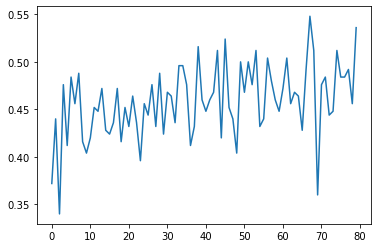

In [32]:
import matplotlib.pyplot as plt
plt.plot(np.arange(80),[np.sum(i==1)/250 for i in np.split(np.array(count), 80)])

In [15]:
len(count)

5